In [1]:
!pip install datasets
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.0 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement tensorflow.keras.applications (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.applications


In [2]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
import tensorflow as tf


In [7]:
!pip install tensorflow_hub tensorflow_text

import tensorflow_hub as hub
import tensorflow_text  # Required for USE
from scipy import spatial

from transformers import RobertaTokenizer, RobertaModel
import torch
from scipy import spatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.3 MB/s eta 0:00:00


In [3]:
dataset = load_dataset('Rohit-D/synthetic-confidential-information-injected-business-excerpts', split = 'test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
import pandas as pd
import csv
import random
import os
import re
import pprint

In [18]:
import matplotlib.pyplot as plt

In [5]:
pp = pprint.PrettyPrinter()
pprint = pp.pprint

# **Llama 7B**

In [22]:
df = pd.read_csv('/content/drive/MyDrive/Conf/fine-tuned-outputs.csv')
df.head()

,OUTPUT
0,.\nThe Zenith product development team has mad...
1,"""\nThe sentence ""We have been facing challenge..."
2,".\nThe sentence ""We have encountered unexpecte..."
3,.\nThe financial benefits from the campaign ha...
4,".\n### Reason: ""Our analysis has revealed that..."


In [132]:
len(df)

88

In [23]:
MODE = 'a'
fh = open('outputs-llama.csv', MODE)
writer = csv.writer(fh)

if MODE == 'w':
  writer.writerow(['OUTPUT'])
  fh.flush()


### **Filter out Replication in Generated Output**

###### **Longest Common Substring**

In [24]:
def lcs(s1, s2):
  n1 = len(s1)
  n2 = len(s2)
  dp = {i : [0] * (n2 + 1) for i in range(n1 + 1)}

  n_lcs = 0

  for i in range(1, n1 + 1):
    for j in range(1, n2 + 1):
      if(s1[i-1] == s2[j-1]):
        dp[i][j] = 1 + dp[i-1][j-1]

      n_lcs = max(n_lcs, dp[i][j])


  return n_lcs

In [135]:
lcs("hello", "hallow")

3

In [25]:
# Records with consecutive sentences having common substrings that are longer than 20% the size of the longer sentence are considered replicas.

def is_replicated(x, y):
  return lcs(x, y) > int(0.2 * max(len(x), len(y)))

In [26]:

for record_ind, record in enumerate(df['OUTPUT'].iloc[:]):
  lines = record.split('\n')
  # pprint({ind : line for ind, line in enumerate(lines)})

  replicated = [ind if ind > 0 and is_replicated(line, lines[ind-1])  else -1 for ind, line in enumerate(lines)]
  replicated = list(filter(lambda x : x >= 0, replicated))
  # print(f'Replication : {replication}')

  out = '\n'.join([line if ind not in replicated else '' for ind, line in enumerate(lines)])
  out = out[2:]
  df['OUTPUT'].iloc[record_ind] = out
  writer.writerow([out])
  print(out, end = '\n------------------------------------\n')

fh.close()

The Zenith product development team has made significant strides in overcoming technical hurdles, ensuring a seamless product launch. This information is confidential as it reveals the company's internal progress and could be used by competitors to gain an advantage.

------------------------------------
The sentence "We have been facing challenges in scaling our operations efficiently, leading to increased costs." is confidential/sensitive information because it reveals internal financial challenges that could impact investor confidence and potentially lead to a decline in stock value.

------------------------------------
The sentence "We have encountered unexpected delays in securing regulatory approvals, which may impact our projected timeline for market entry." is confidential because it discloses sensitive information about the company's regulatory approval process and potential delays, which could be used by competitors to gain an advantage in the market
------------------------

In [27]:
df.head()

,OUTPUT
0,The Zenith product development team has made s...
1,"The sentence ""We have been facing challenges i..."
2,"The sentence ""We have encountered unexpected d..."
3,The financial benefits from the campaign have ...
4,"### Reason: ""Our analysis has revealed that a ..."


In [28]:
target = dataset['Reason']
len(target)

88

In [29]:
len(df)

88

In [30]:
# Load the pre-trained SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:

# Load the Universal Sentence Encoder module
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url) # use - Universal Sentence Encoder

def USE_sentence_similarity(sentence1, sentence2):

    # Encode the input sentences
    embeddings = use_model([sentence1, sentence2])

    # Calculate cosine similarity between the embeddings
    similarity = 1 - spatial.distance.cosine(embeddings[0], embeddings[1])

    return similarity

In [11]:
# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

def roberta_sentence_similarity(sentence1, sentence2):
    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaModel.from_pretrained("roberta-base")

    # Tokenize input sentences and convert them to tensors
    inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model to get sentence embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract sentence embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

    # Flatten the embeddings to 1-D vectors
    embedding1 = embeddings[0].flatten()
    embedding2 = embeddings[1].flatten()

    # Calculate cosine similarity between the embeddings
    similarity = 1 - spatial.distance.cosine(embedding1, embedding2)

    return similarity

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:

cosine_similarities = []
USE_similarities = []
roberta_similarities = []

for i in range(min(len(df), len(target))):
  sentence_1 = df['OUTPUT'].iloc[i]
  sentence_2 = target[i]

  embedding_1 = model.encode(sentence_1)
  embedding_2 = model.encode(sentence_2)

  cosine_similarity = util.cos_sim(embedding_1, embedding_2)
  cosine_similarities.append(cosine_similarity)

  USE_similarity = USE_sentence_similarity(sentence_1, sentence_2)
  USE_similarities.append(USE_similarity)

  roberta_similarity = roberta_sentence_similarity(sentence_1, sentence_2)
  roberta_similarities.append(roberta_similarity)

  pprint((i +1,
          sentence_1,
          sentence_2,
          f'COSINE SIMILARITY : {cosine_similarity}',
          f'USE SENTENCE SIMILARITY : {USE_similarity}',
          f'RoBERT SENTENCE SIMILARITY : {roberta_similarity}'))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(1,
 'The Zenith product development team has made significant strides in '
 'overcoming technical hurdles, ensuring a seamless product launch. This '
 "information is confidential as it reveals the company's internal progress "
 'and could be used by competitors to gain an advantage.\n',
 '"Zenith product development team has made significant strides in overcoming '
 'technical hurdles, ensuring a seamless product launch."**Reason for '
 'confidentiality:** This sentence discloses sensitive information about the '
 "company's internal product development process and technical challenges, "
 'which could provide valuable insights to competitors and potentially '
 "undermine the product's market advantage.",
 'COSINE SIMILARITY : tensor([[0.7120]])',
 'USE SENTENCE SIMILARITY : 0.7770883440971375',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(2,
 'The sentence "We have been facing challenges in scaling our operations '
 'efficiently, leading to increased costs." is confidential/sensitive '
 'information because it reveals internal financial challenges that could '
 'impact investor confidence and potentially lead to a decline in stock '
 'value.\n',
 '"We have been facing challenges in scaling our operations efficiently, '
 'leading to increased costs."This sentence is confidential because it reveals '
 'internal business challenges and inefficiencies that could impact the '
 "company's profitability and investor confidence. Disclosing such information "
 'publicly could raise concerns among investors and competitors and damage the '
 "company's financial stability.",
 'COSINE SIMILARITY : tensor([[0.9300]])',
 'USE SENTENCE SIMILARITY : 0.7214961051940918',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3,
 'The sentence "We have encountered unexpected delays in securing regulatory '
 'approvals, which may impact our projected timeline for market entry." is '
 "confidential because it discloses sensitive information about the company's "
 'regulatory approval process and potential delays, which could be used by '
 'competitors to gain an advantage in the market',
 '"We have encountered unexpected delays in securing regulatory approvals, '
 'which may impact our projected timeline for market entry." This information '
 'is confidential because it could provide competitors with an advantage by '
 'revealing potential vulnerabilities in our regulatory strategy. Disclosing '
 'timelines and approval delays could influence market positioning, strategic '
 'partnerships, and investor confidence.',
 'COSINE SIMILARITY : tensor([[0.8303]])',
 'USE SENTENCE SIMILARITY : 0.7785901427268982',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(4,
 'The financial benefits from the campaign have significantly exceeded its '
 'costs.\n'
 'This information is confidential as it reveals the financial performance of '
 "the company's marketing campaign, which could be used by competitors to gain "
 'an advantage. Disclos',
 '"Increased competition in the market has led to lower prices and higher '
 'production costs, resulting in reduced profitability."This sentence should '
 'be considered confidential because it reveals sensitive financial '
 'information. This information could be used by competitors to gain an '
 "advantage in the market, and it could also damage the company's reputation "
 'with investors and stakeholders.',
 'COSINE SIMILARITY : tensor([[0.6023]])',
 'USE SENTENCE SIMILARITY : 0.5379179120063782',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(5,
 '### Reason: "Our analysis has revealed that a portion of the budget '
 'allocated for influencer marketing was not utilized effectively, leading to '
 'suboptimal results."This information is confidential because it reveals '
 'internal marketing strategies and budget allocation, which could be used by '
 'competitors to gain an unfair advantage. Disclosing this information could '
 "compromise the company's competitive advantage and lead to financial losses",
 '"Our analysis has revealed that a portion of the budget allocated for '
 'influencer marketing was not utilized effectively, leading to suboptimal '
 'results."**Reason for Confidentiality:** This information could be used by '
 'competitors to gain an advantage by identifying weaknesses in our marketing '
 'strategy and exploiting them.',
 'COSINE SIMILARITY : tensor([[0.9209]])',
 'USE SENTENCE SIMILARITY : 0.8551368713378906',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(6,
 'The above sentence is confidential because it reveals sensitive market '
 'research data that could be used by competitors to gain an unfair advantage. '
 'Disclosing such information could compromise our competitive advantage and '
 'lead to a loss of market share.\n',
 '"Our market research indicates a decline in customer loyalty among existing '
 'customers"Confidential due to: Revealing declining customer loyalty could '
 "erode investor confidence and damage the company's reputation, potentially "
 'leading to a loss of market value.',
 'COSINE SIMILARITY : tensor([[0.5453]])',
 'USE SENTENCE SIMILARITY : 0.5386667251586914',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(7,
 'The sentence "Plans to expand the M-Series lineup with a budget-friendly '
 'variant are currently on hold due to supply chain disruptions." is '
 'confidential/sensitive information because it reveals internal business '
 'plans that could impact investor confidence and competitive advantage if '
 'made public.\n'
 'The sentence "',
 '"Plans to expand the M-Series lineup with a budget-friendly variant are '
 'currently on hold due to supply chain disruptions."Reason: This information '
 'is confidential as it could give competitors an advantage by allowing them '
 'to anticipate and adjust their product strategies.',
 'COSINE SIMILARITY : tensor([[0.6911]])',
 'USE SENTENCE SIMILARITY : 0.6453784704208374',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(8,
 'The above sentence contains confidential information about internal sales '
 'projections and potential market trends. This information is not intended '
 'for public disclosure and could be used by competitors to gain an unfair '
 'advantage.\n'
 'The sentence "Internal estimates suggest that demand for Zen products may '
 'slow down in the second half of the year, primarily due to seasonal '
 'factors." is confidential because it reveals sensitive internal sales '
 'projections and market trends that could be used by competitors to gain an '
 'unfair',
 '"Internal estimates suggest that demand for Zen products may slow down in '
 'the second half of the year, primarily due to seasonal factors."This '
 'information is considered confidential because it involves internal sales '
 'projections that are not yet publicly released. Disclosing estimated future '
 'sales trends could give competitors an unfair advantage and disrupt market '
 'positioning.',
 'COSINE SIMILARITY : tensor

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(9,
 'The production delays due to unexpected supply chain disruptions are '
 'confidential/sensitive information.\n',
 '"These issues may affect the availability of Radiance in Q3, which would '
 'impact our projected revenue targets."Revealing the potential production '
 'delays and supply chain disruptions could erode investor confidence and '
 "affect the company's stock price.",
 'COSINE SIMILARITY : tensor([[0.4819]])',
 'USE SENTENCE SIMILARITY : 0.4016992449760437',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(10,
 'The above sentence is confidential because it reveals internal projections '
 'regarding staff shortages in technical support, which could potentially '
 "impact customer satisfaction and the company's reputation. Disclosing such "
 'information could provide competitors with valuable insights and allow them '
 'to adjust their strategies accordingly.\n',
 '"Internal projections indicate a potential staff shortage in technical '
 'support, which could adversely affect customer satisfaction." This sentence '
 "contains confidential information about the company's internal operations "
 'and should not be publicly released, as it could potentially damage the '
 "company's reputation and customer confidence.",
 'COSINE SIMILARITY : tensor([[0.7975]])',
 'USE SENTENCE SIMILARITY : 0.7704812288284302',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(11,
 "The report states that the product's lifespan may be shorter than "
 'anticipated, potentially impacting our competitive advantage in the market.\n'
 '\n',
 '"Our internal testing suggests that Zenith\'s battery life may fall short of '
 'our initial projections under certain usage conditions." - '
 'Confidential.Reason: This information is confidential because it could '
 'impact customer satisfaction and potentially lead to negative publicity if '
 'made public before the issue is resolved.',
 'COSINE SIMILARITY : tensor([[0.3870]])',
 'USE SENTENCE SIMILARITY : 0.35070496797561646',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(12,
 "The financial report contains confidential information about the company's "
 'revenue target for the year. This information is not publicly available and '
 'should not be disclosed to competitors or other parties without proper '
 'authorization.\n',
 '"The delay in the production of key components could have resulted in a '
 'significant loss of revenue." (Reason for confidentiality: This information '
 'could be used by competitors to adjust their own production schedules and '
 'potentially gain market share.)',
 'COSINE SIMILARITY : tensor([[0.4808]])',
 'USE SENTENCE SIMILARITY : 0.4348459839820862',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(13,
 'The confidential analysis of competitor sales data suggests that the market '
 'share of our primary competitor, ZenitCorp, may be larger than previously '
 'estimated. This information is considered confidential because it could '
 'provide our competitors with valuable insights into our market position and '
 'strategies. Revealing this information could compromise our competitive '
 'advantage',
 '"*A confidential analysis of competitor sales data suggests that the market '
 'share of our primary competitor, ZenitCorp, may be larger than previously '
 'estimated.*" This information could potentially undermine our marketing '
 'efforts and lead to competitive disadvantages. Revealing our knowledge of '
 "ZenitCorp's market share could prompt them to respond with countermeasures, "
 'potentially eroding our position in the industry.',
 'COSINE SIMILARITY : tensor([[0.9422]])',
 'USE SENTENCE SIMILARITY : 0.8569985032081604',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(14,
 'The above business excerpt contains confidential information about our '
 'supply chain disruptions, which could be used by competitors to gain an '
 'advantage in the market. This information is not intended for public '
 'disclosure and should be kept confidential.\n',
 '"Supply chain disruptions have impacted our inventory levels, leading to '
 'delays in fulfilling orders for some products."This information is '
 'confidential as it reveals an internal operational challenge that could '
 'potentially affect customer expectations and business continuity. Disclosing '
 'this information publicly could raise customer concerns, damage our '
 'reputation, and provide competitors with an opportunity to exploit our '
 'vulnerabilities.',
 'COSINE SIMILARITY : tensor([[0.8535]])',
 'USE SENTENCE SIMILARITY : 0.5762670040130615',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(15,
 'The confidential company research indicates a potential patent infringement '
 'lawsuit filed by a competitor over our core technology. This information is '
 "considered confidential and sensitive as it could impact the company's "
 'financial performance and reputation if made public.\n',
 '"Confidential company research, however, indicates a potential patent '
 'infringement lawsuit filed by a competitor over our core '
 'technology."**Reason:** Unauthorized disclosure of this information could '
 'alert the competitor of our defensive strategy and possibly give them an '
 'unfair advantage in the legal proceedings.',
 'COSINE SIMILARITY : tensor([[0.9248]])',
 'USE SENTENCE SIMILARITY : 0.7609299421310425',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(16,
 'The confidential/sensitive information in the above business excerpt is '
 '"Despite this success, we have encountered some challenges in maintaining '
 'supply chain efficiency." This information is confidential because it '
 'reveals internal supply chain issues that could potentially impact the '
 "company's competitive advantage if made public.\n"
 'The confidential/sensitive information in the following business excerpt : '
 '"Our marketing campaign for the new "Zenith" product line has been a',
 '"Due to a recent supplier contract dispute, we expect a temporary delay in '
 'the availability of certain Zenith components."Confidential due to sensitive '
 'supplier information that could put the company at a disadvantage in future '
 'negotiations.',
 'COSINE SIMILARITY : tensor([[0.6321]])',
 'USE SENTENCE SIMILARITY : 0.3895595371723175',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(17,
 'The above information is considered highly confidential because it reveals '
 'the financial performance of a new product that has not yet been publicly '
 "disclosed. Disclosing this information could potentially harm the company's "
 'competitive position and financial stability.\n'
 'The following is an example of a confidential/sensitive information in the',
 '"Ongoing discussions with potential investors have revealed that "Zenith" '
 'has yet to break even and may not be profitable in the near future."This '
 'information is confidential because it could impact investor confidence and '
 "potentially affect the company's ability to secure funding.",
 'COSINE SIMILARITY : tensor([[0.5751]])',
 'USE SENTENCE SIMILARITY : 0.527306079864502',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(18,
 'The above sentence is confidential because it reveals our plans to launch a '
 'new line of affordable products, which could give our competitors an '
 'advantage in the market.\n',
 '"We believe that by launching a new line of affordable products, we can gain '
 'a significant market share in the entry-level segment" - This is '
 "confidential because it reveals our company's future product launch plans, "
 'which could give our competitors time to prepare counter-strategies, '
 'potentially harming our market positioning.',
 'COSINE SIMILARITY : tensor([[0.8151]])',
 'USE SENTENCE SIMILARITY : 0.6646436452865601',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(19,
 'The production delays due to unforeseen supply chain disruptions are '
 'confidential/sensitive information. This information could be used by '
 'competitors to gain an advantage in the market by anticipating the release '
 'of the Apex line and potentially adjusting their own production schedules '
 'accordingly. Disclosing this information publicly could also damage the '
 "company's reputation and erode customer trust",
 '"Due to unforeseen supply chain disruptions, we have experienced unexpected '
 'production delays for the Apex product line."(Confidential because this '
 'information could be used by competitors to anticipate our supply chain '
 'issues and make strategic moves to gain an advantage.)',
 'COSINE SIMILARITY : tensor([[0.7989]])',
 'USE SENTENCE SIMILARITY : 0.7223424315452576',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(20,
 'The sales figures for the first quarter of 2023 are confidential and should '
 'not be disclosed publicly. The new marketing campaign targeting Gen-Z '
 'consumers is also confidential and should not be disclosed publicly.',
 '"Our R&D team has also made significant progress on the development of a '
 'revolutionary new software feature, which we believe will set our products '
 'apart in the competitive market."This sentence is confidential because it '
 'reveals proprietary information about an upcoming product feature that could '
 'give our competitors an unfair advantage.',
 'COSINE SIMILARITY : tensor([[0.4645]])',
 'USE SENTENCE SIMILARITY : 0.2645287811756134',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(21,
 'The internal projections indicate a potential slowdown in sales growth, '
 'which is confidential information.\n'
 'The potential acquisition of a promising startup aligns with our long-term '
 'growth strategy, which is sensitive information.\n'
 'The internal projections indicate a potential slowdown in sales growth, '
 'which is confidential information. The potential acquisition',
 '"Internal projections indicate that sales growth may decelerate in the '
 'coming months due to increased competition from emerging rivals."Reason: '
 'This information is confidential because it reveals sensitive financial '
 'projections that, if disclosed publicly, could negatively impact investor '
 "confidence and potentially harm the company's stock price.",
 'COSINE SIMILARITY : tensor([[0.8614]])',
 'USE SENTENCE SIMILARITY : 0.7036459445953369',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(22,
 'The production team has been working tirelessly to address the issue, but a '
 'temporary shortage of key components may impede our ability to fulfill all '
 'orders on time." This information is not intended for public release, as it '
 'could potentially lead to uncertainty among investors and create '
 'opportunities for competitors',
 '"The production team has been working tirelessly to address the issue, but a '
 'temporary shortage of key components may impede our ability to fulfill all '
 'orders on time."This information is confidential because it reveals a '
 "potential supply chain vulnerability that could impact the company's ability "
 'to meet customer demand. Disclosing this information publicly could damage '
 "the company's reputation and lead to speculation about production delays or "
 'potential financial setbacks.',
 'COSINE SIMILARITY : tensor([[0.7573]])',
 'USE SENTENCE SIMILARITY : 0.7309194207191467',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(23,
 'The sales figures for the first quarter of 2023 exceeded expectations. The '
 "marketing campaign, which focused on our brand's commitment to innovation, "
 'was highly successful. Customers responded positively to our new product '
 'line, and we are on track to meet our sales goals for the year. However, '
 'supply chain disruptions',
 '"As a result, we have had to reduce our production targets by 15%."This '
 'information is confidential because it could give our competitors an '
 'advantage. By knowing that we have had to reduce our production targets, '
 'they could adjust their own production plans accordingly and potentially '
 'gain market share.',
 'COSINE SIMILARITY : tensor([[0.3807]])',
 'USE SENTENCE SIMILARITY : 0.3061992824077606',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(24,
 'The above business excerpt contains confidential information about the '
 "company's potential vulnerability to a hostile takeover. This information is "
 'not publicly available and could be used by a competitor to gain an '
 'advantage in negotiations or to plan a takeover.\n',
 '"We are facing a potential threat: the possibility of a hostile takeover by '
 'a competitor."This sentence is confidential as it discloses sensitive '
 "information about a potential threat to the company's position in the "
 "market. Revealing this information publicly could impact the company's stock "
 'price, stakeholder confidence, and business relationships.',
 'COSINE SIMILARITY : tensor([[0.7311]])',
 'USE SENTENCE SIMILARITY : 0.722287654876709',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(25,
 "The AI assistant's voice recognition capabilities have been unreliable, "
 'leading to frustrating user experiences.\n',
 '"The AI assistant has been found to exhibit occasional biases in its '
 'recommendations, potentially leading to unfair treatment of certain user '
 'groups." This information should remain confidential as it could damage our '
 'brand reputation and erode customer trust if it were to be publicly '
 'disclosed.',
 'COSINE SIMILARITY : tensor([[0.4709]])',
 'USE SENTENCE SIMILARITY : 0.3158154785633087',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(26,
 'The revenue shortfall due to a software bug that granted unauthorized access '
 'to premium features is confidential/sensitive information. This information '
 'could be used by competitors to gain an advantage in the market or by '
 "investors to assess the company's financial health. Disclosing this "
 "information could also damage the company's reputation and erode customer "
 'trust',
 '"However, we must address a revenue shortfall due to a software bug that '
 'granted unauthorized access to premium features."  Reason: Public disclosure '
 "of the unauthorized access to premium features could damage the company's "
 'reputation and lead to legal consequences.',
 'COSINE SIMILARITY : tensor([[0.8764]])',
 'USE SENTENCE SIMILARITY : 0.6615113019943237',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(27,
 'The sales projections indicate a potential increase in revenue by up to 15%. '
 'This information is confidential and should not be disclosed publicly.\n'
 '\n'
 'The recent sales period saw a spike in demand for our flagship product, '
 '"Zenith." Sales projections indicate a potential increase in revenue by up '
 'to 15%. This information is confidential',
 '"The estimated delivery time for new orders has been extended by two to '
 'three weeks."This information is confidential because it could lead to '
 'competitors gaining an unfair advantage by adjusting their production or '
 'pricing strategies to capitalize on our supply chain issues. Disclosing such '
 'sensitive information publicly could undermine our competitive position in '
 'the market.',
 'COSINE SIMILARITY : tensor([[0.4771]])',
 'USE SENTENCE SIMILARITY : 0.49096494913101196',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(28,
 'The aggressive pricing strategy has raised concerns internally about its '
 'impact on our profit margins.\n'
 "This information is confidential because it reveals the company's internal "
 'concerns about the pricing strategy for the new laptop, which could be used '
 'by competitors to gain an advantage in the market. Disclosing this '
 "information could lead to price wars and erode the company's profit "
 'margins.\n'
 'The aggressive pricing strategy has raised concerns internally about its',
 'Disclosing the aggressive pricing strategy (The aggressive pricing strategy, '
 'however, has raised concerns internally about its impact on our profit '
 'margins.) could compromise our competitive advantage by revealing sensitive '
 'financial information to rivals. Revealing our pricing decisions could allow '
 'competitors to adjust their pricing or develop alternative products that '
 'undercut our profit margins.',
 'COSINE SIMILARITY : tensor([[0.7426]])',
 'USE SENTENCE SIMIL

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(29,
 'The minor issue with the manufacturing process is confidential information. '
 'It is not publicly disclosed and could be used by competitors to gain an '
 'advantage.\n'
 '"A small number of defective units have been reported, which we are '
 'addressing promptly."\n'
 'This sentence reveals a minor issue with the manufacturing process, which '
 'could be used by competitors to gain an advantage. It is not publicly '
 'disclosed and could be',
 '"We have identified a flaw in the manufacturing process that could '
 'potentially lead to a safety hazard." Reason: Disclosing the specific flaw '
 'could compromise our production secrets and allow competitors to replicate '
 'our processes, potentially undermining our competitive advantage.',
 'COSINE SIMILARITY : tensor([[0.6720]])',
 'USE SENTENCE SIMILARITY : 0.500183641910553',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(30,
 'The disruption in our supply chain is confidential information. It could be '
 'used by competitors to gain an advantage in the market and potentially '
 'disrupt our sales strategy.\n'
 '\n',
 '"We recently encountered a disruption in our supply chain, potentially '
 'compromising our ability to meet the anticipated demand."Reason: This '
 'information is confidential because it could alert competitors to potential '
 'shortages and allow them to adjust their strategies accordingly, potentially '
 'gaining an unfair advantage in the market.',
 'COSINE SIMILARITY : tensor([[0.8647]])',
 'USE SENTENCE SIMILARITY : 0.6977865695953369',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(31,
 'The sentence "Zephyr devices are expected to generate significant revenue '
 'opportunities in',
 '"Zephyr devices are expected to generate significant revenue opportunities '
 'in 2023, accounting for approximately 25% of our annual revenue '
 'projections." - This sentence is considered confidential because it '
 'discloses sensitive financial information that could be used by competitors '
 'to gain an unfair advantage in the smart home market. Revealing such '
 "detailed revenue projections could impact the company's competitive position "
 'and hinder future negotiations with potential investors.',
 'COSINE SIMILARITY : tensor([[0.7069]])',
 'USE SENTENCE SIMILARITY : 0.3874368965625763',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(32,
 '"Zenith\'s software compatibility is currently being tested with a select '
 'group of beta testers." This information is confidential as it could '
 "compromise the product's competitive advantage and potentially expose it to "
 'potential competitors.\n'
 'Confidentiality is a critical aspect of business operations, as it protects',
 '"Advanced negotiations with a leading global carrier have revealed the '
 'projected sales target for Zenith. The carrier has expressed ambitious '
 'aspirations, setting a revenue target exceeding $1 billion by the end of '
 'Q2."Reason: Disclosing confidential sales projections could undermine our '
 'competitive advantage and potentially lead to market manipulation.',
 'COSINE SIMILARITY : tensor([[0.5432]])',
 'USE SENTENCE SIMILARITY : 0.32921043038368225',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(33,
 'The sales pipeline and supply chain disruptions are confidential/sensitive '
 'information.\n'
 '"Our robust sales pipeline is driven by strong demand for our flagship '
 'product, "Zenith." Zenith\'s unique combination of features has resonated '
 'with customers, resulting in a 15% increase in sales in the last quarter." '
 'This information is confidential',
 '"Our supply chain is facing some unexpected disruptions due to a delay in '
 'securing raw materials from a key supplier."This information is confidential '
 "because it could harm the company's reputation by exposing a vulnerability "
 'in its supply chain. Potential investors or competitors might exploit this '
 'knowledge to gain an advantage.',
 'COSINE SIMILARITY : tensor([[0.5790]])',
 'USE SENTENCE SIMILARITY : 0.330036461353302',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(34,
 'The information is confidential because it reveals our production capacity '
 'constraints and overtime costs, which could be used by competitors to gain '
 'an advantage in the market. Disclosing this information could lead to '
 'increased competition and potentially lower profit margins.\n',
 'Disclosing our current production capacity issues could provide valuable '
 'information to competitors, enabling them to adjust their pricing or '
 'production strategies to gain a competitive advantage. Therefore, the '
 'sentence "However, our production capacity has been pushed to its limits to '
 'meet this demand, resulting in increased overtime costs for our factory '
 'workers" is considered confidential.',
 'COSINE SIMILARITY : tensor([[0.6166]])',
 'USE SENTENCE SIMILARITY : 0.6755595207214355',
 'RoBERT SENTENCE SIMILARITY : 0.9999999403953552')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(35,
 'The above sentence is confidential because it reveals sensitive information '
 "about the product's battery life, which could potentially damage the "
 "company's reputation and lead to customer dissatisfaction. Disclosing this "
 'information could also provide competitors with valuable insights into the '
 "product's weaknesses, allowing them to develop strategies to exploit it.\n",
 '"Customer complaints about battery life have been steadily increasing, with '
 'some returns citing the product lasting less than half of the marketed '
 '10-hour usage time."Confidential because it reveals internal quality issues '
 'with the product that could undermine its reputation and lead to potential '
 "product recalls and damage the company's brand image.",
 'COSINE SIMILARITY : tensor([[0.6784]])',
 'USE SENTENCE SIMILARITY : 0.5777937173843384',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(36,
 'The production capacity is currently unable to meet the anticipated demand.\n'
 '\n',
 '"Our production capacity is currently unable to meet the anticipated '
 'demand."Confidential because it could lead to competitors gaining an '
 'advantage by adjusting their own production strategies or engaging in '
 'speculative trading of our stock based on this information.',
 'COSINE SIMILARITY : tensor([[0.5580]])',
 'USE SENTENCE SIMILARITY : 0.40322279930114746',
 'RoBERT SENTENCE SIMILARITY : -0.9999999403953552')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(37,
 'The multi-year contract with the Fortune 500 company is valued at $20 '
 'million. This information is confidential and sensitive as it reveals the '
 'financial value of the contract, which could be used by competitors to gain '
 'an advantage in',
 '"The multi-year contract with the Fortune 500 company is valued at $20 '
 'million." - This information is confidential as it reveals specific '
 'financial details of a major client contract, which could be sensitive and '
 'potentially impact negotiations with other clients.',
 'COSINE SIMILARITY : tensor([[0.9710]])',
 'USE SENTENCE SIMILARITY : 0.7879825234413147',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(38,
 'The increased sales have put a strain on our production capacity, and we are '
 'exploring options to expand our manufacturing capabilities.\n'
 'This information is confidential as it reveals our production capacity '
 'constraints and our plans to expand our manufacturing capabilities. '
 'Disclosing this information could give our competitors an advantage in the '
 'market and allow them to adjust their strategies accordingly.\n'
 'The increased sales have put a strain on our production capacity, and we are '
 'exploring options to expand our manufacturing capabilities. This information '
 'is',
 '"Our current production capacity is insufficient to meet the growing demand, '
 'and we are exploring options to expand our manufacturing '
 'capabilities."Reason for confidentiality: Revealing production capacity '
 'limitations could attract competitors and give them an advantage in planning '
 'their strategies.',
 'COSINE SIMILARITY : tensor([[0.7778]])',
 'USE SENTENCE SIMILARI

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(39,
 'The "BioGreen" product line is a key contributor to our overall '
 'profitability, accounting for 20% of total revenue. The discrepancy in '
 'production costs could potentially impact our profit margins and lead to a '
 'loss of market share if not addressed promptly.\n',
 '"A recent audit revealed a small discrepancy in the production costs for the '
 '"BioGreen" product line."Reason: This information is confidential and could '
 'potentially be exploited by competitors to gain an unfair advantage in '
 'pricing strategies.',
 'COSINE SIMILARITY : tensor([[0.8364]])',
 'USE SENTENCE SIMILARITY : 0.40873491764068604',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(40,
 '### Reason\n'
 '"Zenith\'s launch has been meticulously planned to maximize sales and '
 'establish a formidable presence in the',
 '"Zenith\'s pricing strategy is crucial to our market penetration and '
 'long-term profitability."Reason for Confidentiality: This information is '
 "considered confidential as it reveals the company's strategic pricing "
 'strategy, which is a key element in market competition. Disclosure could '
 'provide competitors with an unfair advantage.',
 'COSINE SIMILARITY : tensor([[0.5306]])',
 'USE SENTENCE SIMILARITY : 0.1135471761226654',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(41,
 'The root cause of the quality issues lies in a manufacturing defect that has '
 'impacted a portion of the products within the new product line. This '
 "information is confidential as it could potentially damage the company's "
 'reputation and impact customer trust. Revealing this information publicly '
 "could lead to a loss of sales and damage the company's brand image.\n"
 '"The root cause of',
 '"The root cause of the quality issues lies in a manufacturing defect that '
 'has impacted a portion of the products within the new product line."The '
 'reason for keeping this information confidential is to prevent competitors '
 'from exploiting the manufacturing defect to their advantage. Disclosing this '
 'information could lead to them gaining insight into our production process '
 'and potentially developing competing products with improved quality.',
 'COSINE SIMILARITY : tensor([[0.8672]])',
 'USE SENTENCE SIMILARITY : 0.7596282958984375',
 'RoBERT SENTENCE SIMILARITY : -

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(42,
 'The confidential plan to launch a new loyalty program exclusively for our '
 'most valued customers is a sensitive piece of information that should not be '
 'shared publicly. This information could give our competitors an unfair '
 'advantage and potentially damage our reputation.\n'
 '\n',
 '"Our marketing team leaked a confidential plan to launch a new loyalty '
 'program exclusively for our most valued customers."This information is '
 'confidential because it could give our competitors an unfair advantage by '
 'providing them with insights into our marketing strategies and customer '
 'segmentation plans, potentially eroding our competitive edge.',
 'COSINE SIMILARITY : tensor([[0.9038]])',
 'USE SENTENCE SIMILARITY : 0.7309562563896179',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(43,
 'The sales team has exceeded expectations this quarter, with a remarkable '
 'growth of 25% compared to the same period last year. The launch of our '
 'innovative product line has been a major driver of this success, capturing '
 'significant market share. However, ongoing negotiations with a key supplier '
 'have hit a snag, potentially impacting our production timeline.\n',
 '"Ongoing negotiations with a key supplier have hit a snag, potentially '
 'impacting our production timeline."Reason: This statement is confidential '
 'because it discloses sensitive information about ongoing business '
 'negotiations, which could affect the supplier relationship and potential '
 'partnerships.',
 'COSINE SIMILARITY : tensor([[0.4224]])',
 'USE SENTENCE SIMILARITY : 0.4214390516281128',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(44,
 "The company's aggressive expansion plans could attract unwelcome attention "
 'from potential competitors.\n',
 '"The company\'s aggressive expansion plans, which could attract unwelcome '
 'attention from potential competitors."This sentence is considered '
 'confidential because:Revealing future business strategies can give '
 'competitors an advantage by allowing them to anticipate and counter the '
 "company's moves, potentially hindering its competitive position in the "
 'market.',
 'COSINE SIMILARITY : tensor([[0.6739]])',
 'USE SENTENCE SIMILARITY : 0.5034418106079102',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(45,
 'The marketing campaign for our new product, the "Zenith" smartphone, has '
 'been a resounding success. Advertisements have generated significant buzz on '
 'social media, and our initial sales projections indicate a record-breaking '
 "launch. However, concerns have been raised about the product's camera "
 'quality, which is a crucial selling point, despite positive feedback from '
 'product reviewers. This information is confidential and sensitive as it '
 'could impact the',
 '"Concerns have been raised about the product\'s camera quality, which is a '
 'crucial selling point" - This sentence is confidential because it reveals a '
 'potential issue with a key feature of the new smartphone. Disclosing this '
 "information to the public before the product's release could lead to "
 'negative publicity and reduced sales.',
 'COSINE SIMILARITY : tensor([[0.6621]])',
 'USE SENTENCE SIMILARITY : 0.7164767980575562',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(46,
 '### Explanation:\n'
 '"The third-party supplier\'s recent acquisition by a competitor may have '
 'disrupted their production process, leading to the defective components."',
 '"The third-party supplier\'s recent acquisition by a competitor may have '
 'disrupted their production process, leading to the defective '
 'components."Reason: Disclosing this information publicly could damage the '
 'vendor relationship and negatively impact future business dealings.',
 'COSINE SIMILARITY : tensor([[0.7121]])',
 'USE SENTENCE SIMILARITY : 0.693387508392334',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(47,
 'The answer is "Internal data analysis revealed an ongoing issue with the '
 'system\'s integration, resulting in occasional data loss." This information '
 "is confidential because it could compromise the security of the company's "
 'customer data and potentially lead to legal or financial consequences.\n',
 '"Internal data analysis revealed an ongoing issue with the system\'s '
 'integration, resulting in occasional data loss." is confidential '
 'because:This information could be used by competitors to exploit '
 'vulnerabilities in our CRM system and gain an unfair advantage.',
 'COSINE SIMILARITY : tensor([[0.8938]])',
 'USE SENTENCE SIMILARITY : 0.696898341178894',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(48,
 'The sentence "Our supplier negotiations have secured a 20% price reduction '
 'on essential materials, effective next quarter." is confidential because it '
 "reveals sensitive information about the company's future pricing strategy. "
 'This information could be used by competitors to gain an unfair advantage in '
 'the market.\n',
 '"Our supplier negotiations have secured a 20% price reduction on essential '
 'materials, effective next quarter."Confidential because: Disclosing the '
 'price reduction agreement with a supplier could potentially give competitors '
 'an unfair advantage in their own negotiations.',
 'COSINE SIMILARITY : tensor([[0.8715]])',
 'USE SENTENCE SIMILARITY : 0.6916324496269226',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(49,
 'The above sentence is confidential because it reveals a potential production '
 'reduction for the Apex smartphone, which could impact investor confidence '
 "and market perception of the company's financial performance. Disclosing "
 'such information prematurely could lead to speculation and uncertainty, '
 'potentially affecting stock prices and investor sentiment.\n',
 '"We are considering reducing production of the Apex smartphone by 15% to '
 'mitigate potential supply constraints."Confidentiality Reason: Premature '
 'disclosure of production adjustments could impact investor confidence and '
 'disrupt ongoing negotiations with suppliers.',
 'COSINE SIMILARITY : tensor([[0.7251]])',
 'USE SENTENCE SIMILARITY : 0.6798475384712219',
 'RoBERT SENTENCE SIMILARITY : -0.9999999403953552')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(50,
 '**Confidential Sentence:** "Eve\'s cleaning cycle employs a proprietary '
 'nanomaterial that disintegrates stubborn grease and residue."This sentence '
 'is confidential because it reveals the specific cleaning mechanism used in',
 '**Confidential Information:** "Eve\'s cleaning cycle employs a proprietary '
 'nanomaterial that disintegrates stubborn grease and residue."**Reason for '
 'Confidentiality:**Revealing the specific components of "Eve\'s" proprietary '
 'cleaning system could provide competitors with valuable insights, enabling '
 'them to develop similar technologies and compromise our competitive '
 'advantage.',
 'COSINE SIMILARITY : tensor([[0.8378]])',
 'USE SENTENCE SIMILARITY : 0.5552531480789185',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(51,
 "The above sentence is confidential because it reveals the company's gross "
 'profit margin, which is a sensitive financial metric that could be used by '
 'competitors to gain an advantage. Disclosing this information could '
 "compromise the company's competitive position and lead to lost revenue.\n"
 '"Our gross profit margin for the last',
 '"Our gross profit margin for the last quarter was 40%, exceeding the '
 'industry average."Reason: Confidential financial information that should not '
 'be publicly released.',
 'COSINE SIMILARITY : tensor([[0.7868]])',
 'USE SENTENCE SIMILARITY : 0.45917046070098877',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(52,
 'The revenue increase of over 20% compared to the same period last year is '
 'confidential/sensitive information.\n'
 '"The team\'s hard work and dedication to promoting our sustainable products '
 'have been instrumental in this achievement." This information',
 'Confidential: "Our research and development team has made a major '
 'breakthrough that has the potential to revolutionize our product line, '
 'leading to even greater sales growth in the future."Reason: Disclosing '
 'information about upcoming research and development projects could give our '
 'competitors an unfair advantage and compromise our long-term sales growth '
 'strategy.',
 'COSINE SIMILARITY : tensor([[0.6449]])',
 'USE SENTENCE SIMILARITY : 0.3191075623035431',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(53,
 'The above sentence is confidential because it discloses our ongoing '
 'negotiations with potential partners and the potential impact on our supply '
 'chain. Revealing this information could compromise our competitive advantage '
 'and potentially lead to lost revenue.\n'
 '"Additionally, our efforts to secure exclusive distribution rights in key '
 'regions have shown promising results."\n'
 'This sentence is confidential because it discloses our ongoing negotiations',
 '"Additionally, our efforts to secure exclusive distribution rights in key '
 'regions have shown promising results." Reason: This sentence discloses '
 'sensitive business strategy related to ongoing negotiations and exclusive '
 'distribution agreements, which could provide competitors with an advantage '
 'if publicly released.',
 'COSINE SIMILARITY : tensor([[0.8192]])',
 'USE SENTENCE SIMILARITY : 0.6431088447570801',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(54,
 'The sales team has exceeded expectations in the first quarter, with a record '
 'number of deals closed. The newly launched marketing campaign has been '
 'highly successful in generating leads, resulting in a 22% increase in sales '
 'pipeline. Despite the positive results, internal analysis indicates a '
 'potential decline in sales in the coming months due to increased '
 'competition.\n'
 'The',
 '"Internal analysis indicates a potential decline in sales in the coming '
 'months due to increased competition" is confidential as it could impact '
 "investor confidence and the company's stock price.",
 'COSINE SIMILARITY : tensor([[0.4735]])',
 'USE SENTENCE SIMILARITY : 0.5232570171356201',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(55,
 'The firmware update contains a feature that allows users to access the '
 "phone's diagnostic functions; however, this feature was intended for "
 'internal testing only and should not have been released to the public. This '
 'information is confidential and sensitive as it could compromise the '
 "security of the phone's diagnostic functions and potentially lead to "
 'unauthorized access.\n'
 'The firm',
 '"The firmware update contains a feature that allows users to access the '
 'phone\'s diagnostic functions."This is confidential because it inadvertently '
 "reveals critical information about the phone's internal software, which "
 'could be used by competitors to exploit potential vulnerabilities or develop '
 'competing products.',
 'COSINE SIMILARITY : tensor([[0.9053]])',
 'USE SENTENCE SIMILARITY : 0.7306417226791382',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(56,
 'The above sentence is confidential because it discloses a potential hardware '
 'defect in a small batch of Zenith smartphones. This information could be '
 'used by competitors to gain an unfair advantage in the market or damage the '
 'reputation of our brand.\n',
 '"Initial quality control evaluations have identified a potential hardware '
 'defect in a small batch of Zenith smartphones." - Reason: This information '
 'is confidential because it could damage consumer confidence in the product '
 'if it were to become public before we have had a chance to fully investigate '
 'and address the issue.',
 'COSINE SIMILARITY : tensor([[0.7718]])',
 'USE SENTENCE SIMILARITY : 0.61601722240448',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(57,
 'The initial budget for the "Ignite" campaign has been exceeded by 15%. This '
 'information is confidential as it could provide competitors with valuable '
 'insights into our marketing strategy and financial performance. Disclosing '
 'this information could compromise our competitive advantage and lead to '
 'increased',
 '"The campaign\'s initial budget has been exceeded by 15%."This information '
 "is confidential because it could negatively impact the company's financial "
 'performance if it were to become public knowledge.',
 'COSINE SIMILARITY : tensor([[0.7150]])',
 'USE SENTENCE SIMILARITY : 0.611987829208374',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(58,
 'The sales team exceeded expectations in Q1, achieving revenue growth of 18%. '
 'This strong performance was driven by increased demand for our flagship '
 'product, the ZenithX. Sales of other products in the lineup remained steady, '
 'contributing to overall revenue growth. However, we faced challenges with '
 'supply chain disruptions that led to production delays for some orders. This '
 'information is confidential as it reveals sensitive production and sales '
 'data',
 '"Sales of other products in the lineup remained steady, contributing to '
 'overall revenue growth."This sentence is confidential because it reveals '
 'that sales of non-flagship products contributed to revenue growth. '
 'Disclosing this information could provide insights to competitors and allow '
 'them to adjust their strategies accordingly, potentially reducing our '
 'competitive advantage.',
 'COSINE SIMILARITY : tensor([[0.5469]])',
 'USE SENTENCE SIMILARITY : 0.6470988392829895',
 'RoBERT SENTEN

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(59,
 'The above sentence is confidential because it reveals sensitive information '
 "about the company's sales performance and marketing strategies. Disclosing "
 'such information could provide competitors with valuable insights into the '
 "company's operations and give them an advantage in the market.\n"
 'The sentence "Despite the competitive landscape, our sales team remains '
 'confident in regaining market share." is confidential because it reveals the '
 "company's internal sales",
 '"Despite the competitive landscape, our sales team remains confident in '
 'regaining market share." This sentence is confidential because it reveals '
 "our internal assessment of the competitive environment and our sales team's "
 'expectations for the future. Releasing this information publicly could '
 'provide our competitors with valuable insights and potentially harm our '
 'market position.',
 'COSINE SIMILARITY : tensor([[0.8863]])',
 'USE SENTENCE SIMILARITY : 0.811529278755188',
 'RoBE

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(60,
 'The above sentence is confidential because it reveals internal testing '
 'results that could compromise product durability and potentially damage '
 "customer trust. Disclosing such information could undermine the product's "
 'reputation and impact sales.\n'
 '"Internal testing has identified potential durability issues that may affect '
 'the longevity of Zenith devices."\n'
 'This sentence is confidential because',
 '"Internal testing has identified potential durability issues that may affect '
 'the longevity of Zenith devices." - This information is confidential because '
 'it could damage the credibility and reputation of our company if disclosed '
 'publicly. Acknowledging potential product defects could undermine consumer '
 'confidence and lead to negative press coverage, ultimately affecting sales '
 'and brand image.',
 'COSINE SIMILARITY : tensor([[0.6883]])',
 'USE SENTENCE SIMILARITY : 0.8067044019699097',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(61,
 'The sentence "Our production and logistics teams are working diligently to '
 'mitigate these issues, and we expect a return to normal inventory levels '
 'within the next six months." is confidential/sens',
 'Revealing the impact of supply chain issues on inventory levels can erode '
 'investor confidence and create uncertainty in the market. Disclosing the '
 'expected timeline for inventory recovery (Our production and logistics teams '
 'are working diligently to mitigate these issues, and we expect a return to '
 'normal inventory levels within the next six months.) could lead to concerns '
 "about the company's ability to meet demand and potentially hurt its stock "
 'price.',
 'COSINE SIMILARITY : tensor([[0.5534]])',
 'USE SENTENCE SIMILARITY : 0.610345184803009',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(62,
 'The new material is believed to be lighter, stronger, and more versatile '
 'than any other material on the market. This information is confidential and '
 'sensitive as it could give our competitors an unfair advantage if they were '
 'to learn about it.\n'
 'The new material is believed to be lighter',
 '"It is believed that the new material will be lighter, stronger, and more '
 'versatile than any other material on the market."Confidential because it '
 'could provide competitors with valuable insights into our future product '
 'development plans, potentially giving them an unfair advantage in the '
 'market.',
 'COSINE SIMILARITY : tensor([[0.6987]])',
 'USE SENTENCE SIMILARITY : 0.7061508297920227',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(63,
 'The discrepancy is due to a miscalculation in the estimated production costs '
 "for one of the product's components. This error could potentially lead to a "
 'loss of revenue if not addressed promptly.\n'
 'The discrepancy in the projected profit margins for certain variations of '
 'the product is confidential/sensitive information.\n',
 '"A review of our pricing strategy revealed a discrepancy in our projected '
 'profit margins for certain variations of the product." - This information is '
 'confidential because disclosing the discrepancy in profit margins could '
 'provide competitors with valuable insights into our product development '
 'costs and strategic decision-making.',
 'COSINE SIMILARITY : tensor([[0.7939]])',
 'USE SENTENCE SIMILARITY : 0.527974009513855',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(64,
 'The production costs associated with Zenith are marginally higher than '
 'initially projected. This information is confidential and sensitive because '
 "it could impact the company's financial projections and marketing strategy. "
 'Disclosing this information to competitors could give them an unfair '
 'advantage in the market.\n',
 '"The production costs associated with Zenith are marginally higher than '
 'initially projected." This information is confidential because it could '
 'provide our competitors with a strategic advantage by revealing our '
 "product's profitability margins, potentially leading to undercutting and "
 'reduced market share.',
 'COSINE SIMILARITY : tensor([[0.9248]])',
 'USE SENTENCE SIMILARITY : 0.7645071744918823',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(65,
 '\n'
 'Our production team has informed us that a slight delay in the release date '
 'may be necessary due to an unexpected surge in component orders."Reason: '
 "Announcing potential delays in production before a product's launch can "
 'create uncertainty and negatively impact customer confidence potentially '
 'leading to lost sales.',
 '"Our production team has informed us that a slight delay in the release date '
 'may be necessary due to an unexpected surge in component orders."Reason: '
 "Announcing potential delays in production before a product's launch can "
 'create uncertainty and negatively impact customer confidence, potentially '
 'leading to lost sales.',
 'COSINE SIMILARITY : tensor([[0.9938]])',
 'USE SENTENCE SIMILARITY : 0.9903010129928589',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(66,
 "The marketing team's recent campaign has led to a remarkable increase in "
 'brand visibility. This information is confidential as it reveals the '
 'effectiveness of the marketing campaign and could be used by competitors to '
 'replicate the strategy.\n'
 '\n'
 'Product sales',
 '"Our production costs have risen slightly due to a recent supplier contract '
 'renegotiation." is confidential as it could give our competitors an '
 'advantage in future negotiations and potentially lead to increased costs for '
 'us.',
 'COSINE SIMILARITY : tensor([[0.3875]])',
 'USE SENTENCE SIMILARITY : 0.3508363664150238',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(67,
 'The confidential/sensitive information in the business excerpt is the '
 'specific target markets for international expansion. This information is '
 'considered confidential as it could provide competitors with valuable '
 'insights into our strategic plans and potentially allow them to adjust their '
 'own strategies accordingly.\n'
 'The confidential/sensitive information in the business ex',
 '"Our recent acquisition of XYZ Industries has encountered some unexpected '
 'challenges, leading to a delay in the integration process."Reason: The '
 'acquisition of XYZ Industries is a confidential transaction that is not yet '
 'public knowledge. Disclosing information about its progress and challenges '
 "could undermine our negotiating position and potentially impact the deal's "
 'success.',
 'COSINE SIMILARITY : tensor([[0.5180]])',
 'USE SENTENCE SIMILARITY : 0.37747880816459656',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(68,
 'The disclosure of our new product pipeline to select clients has raised '
 'concerns about potential leaks of confidential information.\n',
 '"The disclosure of our new product pipeline to select clients has raised '
 'concerns about potential leaks of confidential information."Reason: This '
 'information is considered highly sensitive and should remain confidential to '
 'ensure a competitive advantage in the market.',
 'COSINE SIMILARITY : tensor([[0.9208]])',
 'USE SENTENCE SIMILARITY : 0.7069108486175537',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(69,
 'We are working closely with our suppliers to resolve the issue and ensure '
 'timely delivery."\n'
 'The above sentence is confidential because it discloses sensitive '
 'information about our supply chain challenges and potential revenue impact. '
 'Revealing such information to competitors could give them an unfair '
 'advantage and compromise our compet',
 '"This could pose a challenge in meeting the projected delivery timelines and '
 'impact our revenue growth."This information should remain confidential as it '
 "could create uncertainty among investors and negatively impact our company's "
 'stock price. Revealing potential supply chain challenges could also provide '
 'a competitive advantage to our rivals.',
 'COSINE SIMILARITY : tensor([[0.6881]])',
 'USE SENTENCE SIMILARITY : 0.6873214244842529',
 'RoBERT SENTENCE SIMILARITY : -0.9999999403953552')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(70,
 'The confidential information in the above business excerpt is the unique '
 'patented formula behind Illuminate. This information is considered '
 'confidential as it is a key competitive advantage that could be exploited by '
 'competitors. Disclosing the formula publicly could lead to the development '
 'of similar products by competitors, potentially eroding our market share and '
 'profitability.\n'
 'The confidential information in the above business excerpt',
 '"We have patented a novel encapsulation system that enhances ingredient '
 'efficacy and extends shelf life considerably."Reason: Divulging the patented '
 'formula and its benefits would provide competitors with a strategic '
 'advantage and could potentially erode our competitive edge in the skincare '
 'market.',
 'COSINE SIMILARITY : tensor([[0.5060]])',
 'USE SENTENCE SIMILARITY : 0.4936205744743347',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(71,
 'The sales team has exceeded expectations in the first quarter, surpassing '
 'targets by 12%. This remarkable achievement reflects the effectiveness of '
 'our new marketing campaign. We have also secured exclusive distribution '
 'rights for a promising new product in the healthcare sector. However, due to '
 'a recent product recall, we are experiencing some delays in the shipment of '
 'our flagship product, "Zenith."\n',
 '"Due to a recent product recall, we are experiencing some delays in the '
 'shipment of our flagship product, "Zenith.""Reason: Confidential production '
 'information that could potentially damage customer confidence and lead to '
 'reputational harm.',
 'COSINE SIMILARITY : tensor([[0.7332]])',
 'USE SENTENCE SIMILARITY : 0.5253170728683472',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(72,
 'The revenue increase projection is confidential and sensitive information. '
 'It is not publicly disclosed and could be used by competitors to gain an '
 'advantage.\n'
 "The integration of Acme Corp.'s operations has also presented challenges, "
 'including cultural differences and legacy systems compatibility.\n'
 'This information is confidential and sensitive because it reveals internal '
 'challenges that could be used by competitors to gain an advantage. It could '
 'also impact investor confidence if it were to become public.\n',
 '"The integration of Acme Corp.\'s operations has also presented challenges, '
 'including cultural differences and legacy systems compatibility." '
 '(Confidential)Reason for confidentiality: This sentence discloses internal '
 'challenges faced by the company during the integration process, which could '
 'negatively impact investor confidence and give competitors an advantage.',
 'COSINE SIMILARITY : tensor([[0.7330]])',
 'USE SENTENCE SIMIL

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(73,
 'The "Glow" variant of the Zenith product line has experienced a surge in '
 'demand, driven by an unexpected viral social media trend.\n',
 '"The Glow variant of the Zenith product line has experienced a surge in '
 'demand, driven by an unexpected viral social media trend."Reason for '
 'confidentiality: This information is strategically sensitive as it reveals '
 'proprietary insights into consumer behavior that could be leveraged by '
 'competitors to adjust their own marketing strategies.',
 'COSINE SIMILARITY : tensor([[0.7944]])',
 'USE SENTENCE SIMILARITY : 0.6274753212928772',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(74,
 '"Confidential: Our projections indicate a 10% decline in sales revenue over '
 'the next fiscal quarter due to anticipated economic headwinds."\n'
 'This information',
 '"Confidential: Our projections indicate a 10% decline in sales revenue over '
 'the next fiscal quarter due to anticipated economic headwinds."Reason: This '
 'information is confidential because it could have a negative impact on the '
 "company's stock price and investor confidence if released publicly.",
 'COSINE SIMILARITY : tensor([[0.8931]])',
 'USE SENTENCE SIMILARITY : 0.6908769011497498',
 'RoBERT SENTENCE SIMILARITY : -0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(75,
 'The above sentence is confidential because it discloses proprietary '
 'information about our upcoming product launch and the unique features of our '
 'fitness tracking technology. Revealing such details to competitors could '
 'compromise our competitive advantage and potentially lead to legal action.\n'
 'The sentence "Our proprietary fitness tracking technology',
 '"Our research also revealed that a competitor has recently filed for a '
 'patent that closely resembles our "SyncPulse" technology."This is '
 'confidential because it could provide our competitors with valuable insights '
 'into our product development strategy and potentially allow them to gain an '
 'unfair advantage in the market.',
 'COSINE SIMILARITY : tensor([[0.6454]])',
 'USE SENTENCE SIMILARITY : 0.5569161772727966',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(76,
 'The marketing budget is confidential information that should not be '
 'disclosed publicly. It is important to keep this information private to '
 'avoid giving our competitors an advantage.\n',
 '"We are still working to finalize the marketing budget, which is projected '
 'to be significantly higher than last year." - This information is considered '
 'confidential because it reveals sensitive financial data that could be used '
 'by competitors to gain an advantage.',
 'COSINE SIMILARITY : tensor([[0.8385]])',
 'USE SENTENCE SIMILARITY : 0.6714292764663696',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(77,
 'The quarterly sales report indicates an 8% increase in revenue compared to '
 'the same period last year, driven by strong demand for our flagship software '
 "suite. This information is confidential as it reveals the company's "
 'financial performance, which could be used by competitors to gain an '
 'advantage.\n'
 'The recent expansion plans have encountered unforeseen permit delays, '
 'affecting the opening timeline of our new flagship store. This information '
 'is sensitive',
 '"Recent expansion plans have encountered unforeseen permit delays, affecting '
 'the opening timeline of our new flagship store." - This information is '
 'considered confidential because its premature disclosure could allow '
 'competitors to adjust their strategies and gain a competitive advantage in '
 'terms of timing and market presence.',
 'COSINE SIMILARITY : tensor([[0.6655]])',
 'USE SENTENCE SIMILARITY : 0.7203018665313721',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(78,
 'The internal data analysis shows a decline in conversion rates in certain '
 'key markets, indicating a need for a revised sales strategy. This '
 'information is confidential and sensitive as it reveals a potential weakness '
 'in our sales operations that could be exploited by competitors. Disclosing '
 'this information publicly could compromise our competitive advantage and '
 'lead to a loss of market share.',
 '"Internal data analysis shows that our conversion rates have been declining '
 'in certain key markets, indicating a need for a revised sales strategy."This '
 'information is considered confidential as it could provide valuable insights '
 'to competitors, potentially giving them an advantage in those key markets. '
 'Revealing this data could impact our competitive edge and lead to lost '
 'revenue.',
 'COSINE SIMILARITY : tensor([[0.9385]])',
 'USE SENTENCE SIMILARITY : 0.8484456539154053',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(79,
 'The marketing team is pivoting its strategy to focus on online channels. '
 "This information is confidential as it reveals the company's marketing "
 'strategy and could give competitors an advantage.\n'
 '"Our research indicates that online advertising has a much higher conversion '
 'rate than traditional print media." This information is sensitive as it '
 "reveals the company's internal research findings and could impact the "
 "company's competitive advantage.\n"
 'Employee morale remains high and we expect to see a positive impact on Q4 '
 'revenue.',
 '"Our research indicates that online advertising has a much higher conversion '
 'rate than traditional print media." - This statement divulges proprietary '
 'market research findings which could be analyzed by competitors to gain an '
 'unfair advantage.',
 'COSINE SIMILARITY : tensor([[0.7161]])',
 'USE SENTENCE SIMILARITY : 0.612994909286499',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(80,
 'The analysis of consumer feedback suggests a potential design flaw that '
 "reduces the device's durability under certain usage conditions, posing a "
 'significant risk to our target market. This information is confidential and '
 "sensitive as it could compromise the device's competitive advantage and "
 'impact consumer perception of the product.\n',
 '"Analysis of consumer feedback suggests a potential design flaw that reduces '
 "the device's durability under certain usage conditions, posing a significant "
 'risk to our target market."**Reason for Confidentiality**: Revealing the '
 'specific design flaw responsible for the durability concerns could '
 "compromise the product's competitive advantage and allow competing "
 'manufacturers to exploit the weakness.',
 'COSINE SIMILARITY : tensor([[0.9341]])',
 'USE SENTENCE SIMILARITY : 0.8513263463973999',
 'RoBERT SENTENCE SIMILARITY : 0.9999999403953552')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(81,
 'The financial projections indicate a potential cash flow deficit in the '
 'upcoming quarter, due to unforeseen expenses related to a recent expansion. '
 'This information is confidential and sensitive as it could impact investor '
 "confidence and lead to speculation about the company's financial "
 'stability.\n',
 '"Our financial projections indicate a potential cash flow deficit in the '
 'upcoming quarter, due to unforeseen expenses related to a recent expansion." '
 '(Confidential)This information is considered confidential because it could '
 'potentially damage investor confidence if prematurely released. Disclosure '
 'of financial vulnerabilities can negatively impact our stock price and harm '
 "the company's overall financial stability.",
 'COSINE SIMILARITY : tensor([[0.7881]])',
 'USE SENTENCE SIMILARITY : 0.8231204748153687',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(82,
 "The sales team's ability to nurture customer relationships and identify new "
 'business opportunities is confidential information. The audit revealed an '
 'isolated incident of expense overspending by a sales manager in the Western '
 'region, totaling $33,000. This information is sensitive as it could damage '
 'the company',
 '"A sales manager in the Western region overspent expenses by $33,000." - '
 "This information is confidential as it could compromise the sales manager's "
 'reputation and potentially lead to security issues within the company.',
 'COSINE SIMILARITY : tensor([[0.7809]])',
 'USE SENTENCE SIMILARITY : 0.717819333076477',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(83,
 'The confidential/sensitive information in the above business excerpt is the '
 'initial production costs for the Zenith line, which have come in slightly '
 'higher than expected. This information is confidential because it could be '
 'used by competitors to gain an unfair advantage in the market.\n'
 'The confidential/sensitive information in the following business excer',
 '"Initial production costs for the Zenith line have come in slightly higher '
 'than expected," is confidential because releasing information about '
 'production costs can give our competitors an advantage in terms of pricing '
 'their own products.',
 'COSINE SIMILARITY : tensor([[0.8023]])',
 'USE SENTENCE SIMILARITY : 0.6542505025863647',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(84,
 'The increased workload has put a strain on our customer support team, '
 'resulting in longer wait times for customers. This information is '
 "confidential as it reveals the company's internal challenges and could be "
 'used by competitors to gain an advantage.\n',
 '"The increased workload has put a strain on our customer support team, '
 'resulting in longer wait times for customers."Reason for confidentiality: '
 "This information is sensitive and could damage the company's reputation if "
 'disclosed publicly. Extended wait times could lead to customer '
 'dissatisfaction and negative feedback, potentially impacting sales and brand '
 'loyalty.',
 'COSINE SIMILARITY : tensor([[0.8609]])',
 'USE SENTENCE SIMILARITY : 0.7451142072677612',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(85,
 'The production delays could potentially affect our ability to meet the '
 'anticipated increase in demand. This information is confidential as it could '
 'provide our competitors with an advantage in planning their own production '
 'schedules.\n',
 '"We have encountered some delays in the production of certain components, '
 'which could potentially affect our ability to meet the anticipated increase '
 'in demand."This information is confidential as it could give our competitors '
 'an advantage by allowing them to adjust their production plans and '
 'potentially gain market share.',
 'COSINE SIMILARITY : tensor([[0.8833]])',
 'USE SENTENCE SIMILARITY : 0.7780474424362183',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(86,
 'The expected revenue projections for Zenith far exceed our initial '
 'forecasts.\n'
 "This information is confidential as it reveals the company's financial "
 'projections for a specific product, which could be used by competitors to '
 'gain an unfair advantage. Disclosing such information could compromise the '
 "company's competitive position and potentially lead to financial losses.\n"
 '"The expected re',
 '"The expected revenue projections for Zenith far exceed our initial '
 'forecasts, indicating a potential financial windfall for the company."This '
 'sentence is confidential because it contains sensitive financial information '
 'that could give our competitors an unfair advantage in the market if '
 'publicly released.',
 'COSINE SIMILARITY : tensor([[0.8362]])',
 'USE SENTENCE SIMILARITY : 0.8188005685806274',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(87,
 '',
 'The confidential information disclosed is: "Our internal research suggests '
 'that 5G-enabled smartphones will account for over 50% of smartphone sales by '
 '2025."Reason: This information is not yet public and could give our '
 'competitors an unfair advantage if they were to learn about it.',
 'COSINE SIMILARITY : tensor([[0.0232]])',
 'USE SENTENCE SIMILARITY : 0.08189181238412857',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(88,
 'The confidential/sensitive information in the business excerpt is "With new '
 'features set to release in the coming months, we are confident this software '
 'will maintain its popularity." This information is confidential because it '
 "reveals the company's future product plans, which could give competitors an "
 'advantage in the market.\n',
 '"Also, thanks to a recent executive decision, employee bonuses will be '
 'doubled this quarter." - Confidential because this information is not yet '
 'public and could give competitors an unfair advantage.',
 'COSINE SIMILARITY : tensor([[0.6441]])',
 'USE SENTENCE SIMILARITY : 0.5414000153541565',
 'RoBERT SENTENCE SIMILARITY : 1')


In [32]:
x = range(len(cosine_similarities))
y1 = [cos_sim[0].item() for cos_sim in cosine_similarities]
y2 = USE_similarities
y3 = roberta_similarities

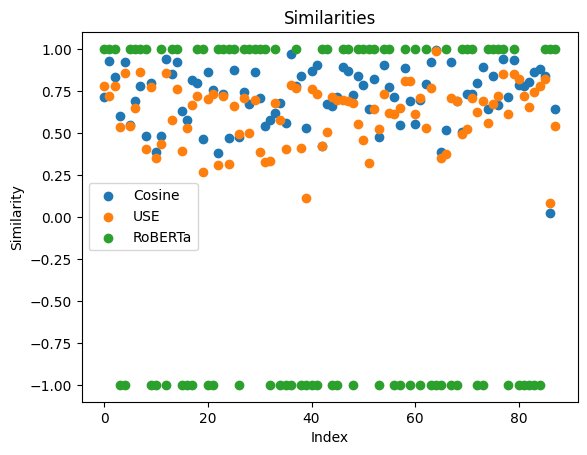

In [33]:
plt.title('Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.legend(['Cosine', 'USE', 'RoBERTa'])
plt.show()

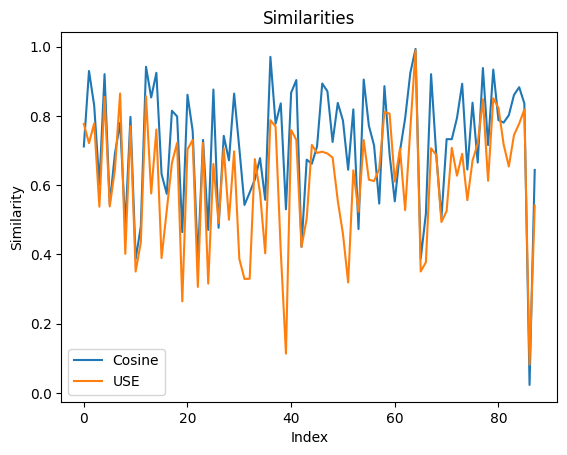

In [34]:
plt.title('Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Cosine', 'USE'])
# plt.plot(x, y3)
# plt.legend(['Cosine', 'USE', 'RoBERTa'])
plt.show()

In [35]:
import torch

In [36]:
type(cosine_similarities)

list

In [37]:
print('COSINE SIMILARITY')
print(f'MEAN : {torch.mean(torch.Tensor(cosine_similarities).squeeze())}')
print(f'MEDIAN : {torch.median(torch.Tensor(cosine_similarities).squeeze())}')


COSINE SIMILARITY
MEAN : 0.7170656323432922
MEDIAN : 0.7329938411712646


In [38]:
print('USE SIMILARITY')
print(f'MEAN : {torch.mean(torch.Tensor(USE_similarities).squeeze())}')
print(f'MEDIAN : {torch.median(torch.Tensor(USE_similarities).squeeze())}')


USE SIMILARITY
MEAN : 0.6120994091033936
MEDIAN : 0.6615113019943237


# **Falcon 7B**

In [50]:
fal_df = pd.read_csv('/content/drive/MyDrive/Conf/outputs-falcon-7b.csv')
fal_df.head()

,OUTPUT
0,Identify if there is any confidential/sensitiv...
1,Identify if there is any confidential/sensitiv...
2,Identify if there is any confidential/sensitiv...
3,Identify if there is any confidential/sensitiv...
4,Identify if there is any confidential/sensitiv...


In [51]:
target = dataset['Reason']
excerpts = dataset['Excerpt']
len(target)

88

In [52]:
system_prompt = 'Identify if there is any confidential/sensitive information in the following business excerpt :\n<EXCERPT>: '

In [53]:
MODE = 'w'
fh = open('outputs-falcon.csv', MODE)
writer = csv.writer(fh)

if MODE == 'w':
  writer.writerow(['OUTPUT'])
  fh.flush()

In [54]:

fal_cosine_similarities = []
fal_USE_similarities = []
fal_roberta_similarities = []

for i in range(min(len(df), len(target))):
  sentence_1 = fal_df['OUTPUT'].iloc[i][len(system_prompt) + len(excerpts[i]):]
  sentence_2 = target[i]

  embedding_1 = model.encode(sentence_1)
  embedding_2 = model.encode(sentence_2)

  fal_cosine_similarity = util.cos_sim(embedding_1, embedding_2)
  fal_cosine_similarities.append(fal_cosine_similarity)

  fal_USE_similarity = USE_sentence_similarity(sentence_1, sentence_2)
  fal_USE_similarities.append(fal_USE_similarity)

  fal_roberta_similarity = roberta_sentence_similarity(sentence_1, sentence_2)
  fal_roberta_similarities.append(fal_roberta_similarity)

  pprint((i +1,
          sentence_1,
          sentence_2,
          f'COSINE SIMILARITY : {fal_cosine_similarity}',
          f'USE SENTENCE SIMILARITY : {fal_USE_similarity}',
          f'RoBERT SENTENCE SIMILARITY : {fal_roberta_similarity}'))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(1,
 ' However, we must exercise caution in disclosing specific details about the '
 "product's design and functionality, as premature disclosure could compromise "
 'our competitive advantage and potentially harm future sales.\n'
 '"The Zenith product development team has made significant strides in '
 'overcoming technical hurdles, ensuring a seamless product launch."This '
 'sentence contains confidential information that should not be publicly '
 "disclosed because it reveals sensitive details about the product's "
 'development process and potential vulnerabilities. Disclosing such '
 'information prematurely could provide competitors with an unfair advantage '
 "and negatively impact the company's financial performance.\n"
 '"Marketing campaigns are currently being refined to maximize brand '
 'visibility and drive consumer engagement."This sentence contains '
 'confidential information',
 '"Zenith product development team has made significant strides in overcoming '
 'technical 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(2,
 ' (Confidential Reason: "We have been facing challenges in scaling our '
 'operations efficiently, leading to increased costs.")\n'
 '"We have been facing challenges in scaling our operations efficiently, '
 'leading to increased costs." (Confidential Reason: "We have been facing '
 'challenges in scaling our operations efficiently, leading to increased '
 'costs.") - This sentence is considered confidential because it discloses '
 "sensitive financial information about the company's operational efficiency "
 'and potential future costs. Disclosing this information could provide '
 "competitors with an unfair advantage and impact the company's stock price.\n"
 '"Our sales team has exceeded expectations, generating record-breaking '
 'revenue for',
 '"We have been facing challenges in scaling our operations efficiently, '
 'leading to increased costs."This sentence is confidential because it reveals '
 'internal business challenges and inefficiencies that could impact the '
 "compa

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3,
 ' (Confidential Reason: Disclosing the specific nature of the regulatory '
 'delay could compromise our competitive advantage and potentially lead to '
 'investor concerns.)',
 '"We have encountered unexpected delays in securing regulatory approvals, '
 'which may impact our projected timeline for market entry." This information '
 'is confidential because it could provide competitors with an advantage by '
 'revealing potential vulnerabilities in our regulatory strategy. Disclosing '
 'timelines and approval delays could influence market positioning, strategic '
 'partnerships, and investor confidence.',
 'COSINE SIMILARITY : tensor([[0.7795]])',
 'USE SENTENCE SIMILARITY : 0.6031550765037537',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(4,
 ' "We are exploring strategic partnerships with other companies to expand our '
 'product line and reach new markets." (Confidential Reason: Revealing '
 'specific details about future partnerships could compromise our competitive '
 'advantage and allow competitors to adjust their strategies accordingly.) '
 '"Our research and development team is working on developing a revolutionary '
 'new product that will revolutionize the industry." (Confidential Reason: '
 'Disclosing the specifics of this project could give our competitors an '
 'unfair advantage by allowing them to develop countermeasures or preemptively '
 'adapt their own products.) "The company\'s recent acquisition of a major '
 'competitor has expanded our market share and strengthened our position',
 '"Increased competition in the market has led to lower prices and higher '
 'production costs, resulting in reduced profitability."This sentence should '
 'be considered confidential because it reveals sensitive financi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(5,
 '\n'
 '**Reason for Confidentiality:** Disclosing the ineffective use of influencer '
 "marketing budget could damage the company's reputation and potentially "
 'impact future partnerships. Revealing this information publicly could also '
 'provide competitors with valuable insights into our marketing strategies and '
 'tactics.\n'
 '**Reason for Confidentiality:** Disclosing the ineffective use of influencer '
 "marketing budget could damage the company's reputation and potentially "
 'impact future partnerships. Revealing this information publicly could also '
 'provide competitors with valuable insights into our marketing strategies and '
 'tactics.\n'
 '**Reason for Confidentiality:** Disclosing the ineffective use of influencer '
 "marketing budget could damage the company's reputation and potentially "
 'impact future partnerships.',
 '"Our analysis has revealed that a portion of the budget allocated for '
 'influencer marketing was not utilized effectively, leading to subo

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(6,
 ' (Confidential Reason: Revealing potential customer churn issues could '
 'negatively affect investor confidence and lead to stock price volatility.)\n'
 'Reason for Confidentiality: Disclosing potential customer churn issues could '
 'negatively affect investor confidence and lead to stock price volatility. '
 '"Revealing potential customer churn issues could significantly impact our '
 'long-term revenue growth." (Confidential Reason: Revealing potential '
 'customer churn issues could significantly impact our long-term revenue '
 'growth.)\n'
 'Reason for Confidentiality: Revealing potential customer churn issues could '
 'significantly impact our long-term revenue growth. "Revealing potential '
 'customer churn issues could significantly impact our long-term',
 '"Our market research indicates a decline in customer loyalty among existing '
 'customers"Confidential due to: Revealing declining customer loyalty could '
 "erode investor confidence and damage the company's reputati

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(7,
 ' However, we have encountered some unexpected challenges in production of '
 "the Apex M-Series's proprietary battery technology, which may impact future "
 'shipments. "We expect to resolve these issues within the next six months." '
 '(Confidential Reason: Disclosing potential production delays or supply chain '
 'disruptions could erode investor confidence and negatively impact stock '
 'prices.)',
 '"Plans to expand the M-Series lineup with a budget-friendly variant are '
 'currently on hold due to supply chain disruptions."Reason: This information '
 'is confidential as it could give competitors an advantage by allowing them '
 'to anticipate and adjust their product strategies.',
 'COSINE SIMILARITY : tensor([[0.6568]])',
 'USE SENTENCE SIMILARITY : 0.4549897313117981',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(8,
 ' We are exploring strategic partnerships with major retailers to boost sales '
 'and expand distribution channels. (Confidential Reason: Disclosing potential '
 'seasonal slowdown in demand could impact investor confidence and lead to '
 'stock price volatility.)\n'
 'Reason for Confidentiality: Revealing potential seasonal slowdown in demand '
 'could impact investor confidence and lead to stock price volatility. This '
 "information is considered confidential because it could affect the company's "
 'financial performance and stock price. Disclosing potential seasonal '
 'slowdown in demand could also provide competitors with valuable insights '
 "into the company's future plans and strategies.\n"
 'Reason for Confidentiality: Disclosing potential seasonal slowdown in demand '
 'could provide competitors with valuable',
 '"Internal estimates suggest that demand for Zen products may slow down in '
 'the second half of the year, primarily due to seasonal factors."This '
 'informa

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(9,
 '\n'
 '"Production delays due to unexpected supply chain disruptions" is considered '
 'confidential because it could provide competitors with valuable insights '
 'into our current challenges and potentially lead to competitive advantage. '
 'Disclosing such information publicly could compromise our competitive '
 'position and allow them to adjust their strategies accordingly.\n'
 '"These issues may affect the availability of Radiance in Q3, which would '
 'impact our projected revenue targets." This sentence is confidential because '
 'it reveals sensitive financial projections that could be used by competitors '
 'to gain an unfair advantage in the market. Disclosing this information '
 'publicly could damage our reputation and give our competitors an unfair '
 'advantage.\n'
 '"The recent surge in sales has propelled',
 '"These issues may affect the availability of Radiance in Q3, which would '
 'impact our projected revenue targets."Revealing the potential production '
 'del

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(10,
 ' This information is confidential because it could impact investor '
 'confidence and potentially lead to stock price volatility. Disclosing such '
 'sensitive data publicly could also provide competitors with an unfair '
 'advantage.\n'
 '"Internal projections indicate a potential staff shortage in technical '
 'support, which could adversely affect customer satisfaction."This sentence '
 'is confidential because it discloses internal projections that could be used '
 'by competitors to gain an unfair advantage in staffing or pricing '
 'strategies. Revealing this information publicly could compromise the '
 "company's competitive position and allow competitors to adjust their own "
 'strategies accordingly. Additionally, disclosing internal projections can '
 'lead to speculation about future financial performance, which could impact '
 'investor sentiment and potentially drive down share',
 '"Internal projections indicate a potential staff shortage in technical '
 'support, w

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(11,
 ' The report suggests that the product may be susceptible to premature wear '
 'and tear, which could potentially impact its long-term viability.\n'
 '"The report suggests that the product may be susceptible to premature wear '
 'and tear, which could potentially impact its long-term viability."This '
 'sentence contains confidential information about the potential durability '
 'issues with Zenith, which could negatively affect investor confidence and '
 'lead to reduced demand for the product. Disclosing this information '
 "prematurely could damage the company's reputation and stock price.\n"
 '"We have been working diligently to address these concerns and are confident '
 'that we will resolve them before the product launch."This sentence reveals '
 'sensitive internal discussions',
 '"Our internal testing suggests that Zenith\'s battery life may fall short of '
 'our initial projections under certain usage conditions." - '
 'Confidential.Reason: This information is confident

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(12,
 ' "We anticipate a surge in demand for Zenith in the coming months, which '
 'could potentially exceed our current production capacity." (Confidential '
 'Reason: Revealing potential supply chain issues could lead to speculation '
 'and panic among investors.)\n'
 'Reason for Confidentiality: Disclosing potential supply chain issues could '
 'lead to speculation and panic among investors, potentially impacting stock '
 'prices and investor confidence. This information is considered confidential '
 "because it could affect the company's financial performance and stock price. "
 'Revealing potential supply chain issues could also provide competitors with '
 'an advantage by allowing them to adjust their strategies accordingly.\n'
 'Reason for Confidentiality: Revealing potential supply chain',
 '"The delay in the production of key components could have resulted in a '
 'significant loss of revenue." (Reason for confidentiality: This information '
 'could be used by competitors to a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(13,
 ' This could potentially impact our revenue projections. "We are confident '
 "that our new product will outperform ZenitCorp's offerings in terms of both "
 'performance and price." (Confidential Reason: Revealing the potential market '
 'share of ZenitCorp could compromise our competitive advantage.) "Our '
 'marketing campaign has been highly successful, generating significant buzz '
 'and pre-orders." (Confidential Reason: Revealing the success of our '
 'marketing campaign could alert competitors to our strategy and allow them to '
 'adjust their own campaigns accordingly.) "The X-2000C\'s projected sales '
 'figures are significantly higher than those of our previous model, '
 'indicating strong',
 '"*A confidential analysis of competitor sales data suggests that the market '
 'share of our primary competitor, ZenitCorp, may be larger than previously '
 'estimated.*" This information could potentially undermine our marketing '
 'efforts and lead to competitive disadvantages

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(14,
 '\n'
 '"Supply chain disruptions have impacted our inventory levels, leading to '
 'delays in fulfilling orders for some products."This sentence contains '
 'confidential information about potential supply chain issues that could '
 "impact customer satisfaction and negatively affect the company's reputation. "
 'Disclosing such information publicly could erode consumer confidence and '
 "damage the company's brand image.\n"
 '"Our sales team has exceeded projections for the third quarter, resulting in '
 'a record-breaking performance."This sentence reveals sensitive financial '
 'data that could be used by competitors to gain an advantage or exploit our '
 'business strategy. Disclosing such information publicly could compromise our '
 'competitive edge and lead to increased competition.\n'
 '"The',
 '"Supply chain disruptions have impacted our inventory levels, leading to '
 'delays in fulfilling orders for some products."This information is '
 'confidential as it reveals an i

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(15,
 ' (Confidential Reason: Revealing the existence of a potential patent '
 'infringement lawsuit could negatively affect investor confidence and lead to '
 'stock price volatility.)\n'
 'Reason for confidentiality: Revealing the existence of a potential patent '
 'infringement lawsuit could negatively affect investor confidence and lead to '
 'stock price volatility.\n'
 'Why is it confidential? Disclosing the existence of a potential patent '
 'infringement lawsuit could lead to stock price volatility and potentially '
 'damage investor confidence. This information is sensitive because it could '
 'provide an advantage to competitors who might exploit the situation to gain '
 "market share or weaken the company's negotiating position.\n"
 'Reason for confidentiality: Revealing the existence of a potential patent '
 'infringement',
 '"Confidential company research, however, indicates a potential patent '
 'infringement lawsuit filed by a competitor over our core '
 'technology."**R

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(16,
 '\n'
 '"The team\'s innovative approach in targeting key demographics led to an '
 'impressive 20% increase in revenue compared to the previous quarter." This '
 'sentence contains confidential financial information that could be used by '
 'competitors to gain an advantage in pricing or market positioning. '
 'Disclosing such sensitive data could compromise our competitive position and '
 'potentially lead to lost profits.\n'
 '"However, despite this success, we have encountered some challenges in '
 'maintaining supply chain efficiency." This sentence reveals internal '
 'operational issues that could impact customer satisfaction and employee '
 'morale. Disclosing these problems publicly could damage our reputation and '
 'erode trust in our ability to deliver consistent quality products.\n'
 '"We',
 '"Due to a recent supplier contract dispute, we expect a temporary delay in '
 'the availability of certain Zenith components."Confidential due to sensitive '
 'supplier informati

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(17,
 ' "Zenith\'s" projected profitability is currently being evaluated by our '
 'financial advisors, and we are exploring strategic options to address its '
 'current challenges. We anticipate releasing more detailed financial '
 'projections in the upcoming quarterly report. "Zenith\'s" projected '
 'profitability is currently being evaluated by our financial advisors, and we '
 'are exploring strategic options to address its current challenges. We '
 'anticipate releasing more detailed financial projections in the upcoming '
 'quarterly report. "Zenith\'s" projected profitability is currently being '
 'evaluated by our financial advisors, and we are exploring strategic options '
 'to address its current challenges. We anticipate releasing more detailed '
 'financial projections in the upcoming quarterly report',
 '"Ongoing discussions with potential investors have revealed that "Zenith" '
 'has yet to break even and may not be profitable in the near future."This '
 'information is

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(18,
 ' (Confidential).\n'
 '"We are also exploring strategic partnerships with local distributors to '
 'expand our reach into emerging markets." (Confidential)\n'
 '"Our sales team has been performing exceptionally well, exceeding targets by '
 'a considerable margin." (Confidential)\n'
 '"However, we have encountered some challenges in meeting demand for our '
 'flagship product, due to supply chain disruptions." (Confidential)\n'
 '"We anticipate a potential delay in the launch of our upcoming product line, '
 'which could impact our revenue projections for the next quarter." '
 '(Confidential)\n'
 '"The recent acquisition of a competitor\'s intellectual property rights has '
 'significantly strengthened',
 '"We believe that by launching a new line of affordable products, we can gain '
 'a significant market share in the entry-level segment" - This is '
 "confidential because it reveals our company's future product launch plans, "
 'which could give our competitors time to prepare 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(19,
 ' We are confident that our team will overcome these obstacles and continue '
 'to deliver exceptional products to our loyal customers.\n'
 '"Confidential Reason: Disclosing potential supply chain disruptions could '
 'erode customer confidence and lead to negative publicity."Reason for '
 'Confidentiality: Revealing potential supply chain disruptions could impact '
 "investor confidence and damage the company's reputation. Disclosing such "
 'information publicly could also provide competitors with an advantage in the '
 'market. Disclosing supply chain issues could also lead to legal action '
 'against the company.\n'
 '"Confidential Reason: Revealing potential supply chain disruptions could '
 'impact investor confidence and damage the company\'s reputation."Reason for '
 'Confidential',
 '"Due to unforeseen supply chain disruptions, we have experienced unexpected '
 'production delays for the Apex product line."(Confidential because this '
 'information could be used by compe

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(20,
 '\n'
 '"Our R&D team has also made significant progress on the development of a '
 'revolutionary new software feature, which we believe will set our products '
 'apart in the competitive market."This sentence contains confidential '
 "information about the company's future product development plans, which "
 'could provide competitors with an unfair advantage if released prematurely. '
 "Disclosing such details publicly could compromise the company's strategic "
 'position and potentially lead to lost revenue opportunities.\n'
 '"However, we are cautiously optimistic due to concerns over potential supply '
 'chain disruptions and rising production costs."This sentence reveals '
 'sensitive financial projections that could impact investor confidence and '
 'stock prices if released publicly. Disclosing this information',
 '"Our R&D team has also made significant progress on the development of a '
 'revolutionary new software feature, which we believe will set our products '
 'apa

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(21,
 '\n'
 '"Internal projections indicate that sales growth may decelerate in the '
 'coming months due to increased competition from emerging rivals."This '
 'sentence contains confidential financial information that could impact '
 "investor confidence and potentially harm the company's stock price if "
 'released prematurely. Disclosing this information publicly before it is '
 'officially announced could lead to speculation and volatility in the stock '
 'market, potentially eroding shareholder value.\n'
 '"Our market research team has identified a potential opportunity to acquire '
 'a promising startup that aligns with our long-term growth strategy."This '
 'sentence contains sensitive strategic information that should not be made '
 'public until after negotiations have been finalized and a definitive '
 'agreement has been reached.',
 '"Internal projections indicate that sales growth may decelerate in the '
 'coming months due to increased competition from emerging rivals."Re

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(22,
 ' "We are confident that we will be able to resolve this situation within the '
 'next quarter." (Confidential Reason: Disclosing potential supply chain '
 'issues or production delays can impact investor confidence and provide an '
 'advantage to competitors.)\n'
 '"The production team has been working tirelessly to address the issue, but a '
 'temporary shortage of key components may impede our ability to fulfill all '
 'orders on time." - ConfidentialReason: Disclosing potential supply chain '
 'issues or production delays can impact investor confidence and provide an '
 'advantage to competitors. "We are confident that we will be able to resolve '
 'this situation within the next quarter." - ConfidentialReason:',
 '"The production team has been working tirelessly to address the issue, but a '
 'temporary shortage of key components may impede our ability to fulfill all '
 'orders on time."This information is confidential because it reveals a '
 "potential supply chain vulnerab

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(23,
 '\n'
 '"Supply chain disruptions have affected the production of our flagship '
 'product, "Synergy." As a result, we have had to reduce our production '
 'targets by 15%."This sentence contains confidential information about the '
 "company's production capacity and potential revenue loss due to supply chain "
 'disruptions. Disclosing this information publicly could impact investor '
 'confidence and lead to financial losses.\n'
 '"The marketing campaign, which focused on our brand\'s commitment to '
 'innovation, was highly successful."This sentence contains confidential '
 "information about the company's marketing strategy and its effectiveness. "
 'Disclosing this information publicly could give competitors an advantage and '
 'undermine future campaigns.\n',
 '"As a result, we have had to reduce our production targets by 15%."This '
 'information is confidential because it could give our competitors an '
 'advantage. By knowing that we have had to reduce our production tar

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(24,
 ' "We have recently acquired a patent for a revolutionary technology that '
 'could revolutionize the industry." - Confidential (Reason: Revealing the '
 'acquisition of a patent for a revolutionary technology could provide '
 'competitors with valuable insights into our future product development plans '
 'and potentially give them an advantage.) "Our sales projections indicate a '
 'steady increase in demand over the next few quarters, driven by positive '
 'customer feedback and anticipated product launches." - Confidential (Reason: '
 'Revealing specific sales projections could allow competitors to adjust their '
 'strategies and gain an unfair advantage.) "The recent surge in demand has '
 'put pressure on our supply chain, resulting in delays in fulfilling',
 '"We are facing a potential threat: the possibility of a hostile takeover by '
 'a competitor."This sentence is confidential as it discloses sensitive '
 "information about a potential threat to the company's position 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(25,
 " The AI assistant's voice recognition software has been found to be "
 'susceptible to false triggers, potentially compromising user privacy.\n'
 '"The AI assistant\'s voice recognition software has been found to be '
 'susceptible to false triggers, potentially compromising user privacy."This '
 'sentence contains confidential information about a potential security '
 "vulnerability in the AI assistant's voice recognition software. Disclosing "
 'this information publicly could compromise customer trust and damage the '
 "company's reputation. It should not be released until it can be addressed "
 'confidentially.\n'
 '"We have identified a potential security vulnerability in the AI '
 "assistant's voice recognition software that could allow unauthorized access "
 'to sensitive data."This sentence',
 '"The AI assistant has been found to exhibit occasional biases in its '
 'recommendations, potentially leading to unfair treatment of certain user '
 'groups." This information sho

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(26,
 '\n'
 '"We must address a revenue shortfall due to a software bug that granted '
 'unauthorized access to premium features."Reason for Confidentiality: '
 'Revealing the existence of a software bug that grants unauthorized access to '
 "premium features could damage the company's reputation and lead to legal "
 'action by affected customers. Disclosing such a vulnerability publicly could '
 'also compromise future product development and sales.\n'
 '"Despite our best efforts to contain the issue, word has spread, resulting '
 'in a decline in new paid subscribers."Reason for Confidentiality: Revealing '
 'the impact of a software bug on customer retention could undermine investor '
 "confidence and negatively affect the company's stock price.",
 '"However, we must address a revenue shortfall due to a software bug that '
 'granted unauthorized access to premium features."  Reason: Public disclosure '
 "of the unauthorized access to premium features could damage the company's "
 'r

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(27,
 ' This delay could impact customer satisfaction and potentially lead to lost '
 'sales opportunities.\n'
 '"The estimated delivery time for new orders has been extended by two to '
 'three weeks."This sentence contains confidential information about the '
 "company's production schedule and potential delays in fulfilling customer "
 'orders. Disclosing this information publicly could erode consumer confidence '
 "and damage the company's reputation.\n"
 '"Supply chain disruptions have caused a temporary shortage of certain '
 'components, and the estimated delivery time for new orders has been extended '
 'by two to three weeks."This sentence reveals sensitive information about the '
 "company's current supply chain challenges, which could be exploited by "
 'competitors or used to adjust pricing',
 '"The estimated delivery time for new orders has been extended by two to '
 'three weeks."This information is confidential because it could lead to '
 'competitors gaining an unfair a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(28,
 ' "We are exploring potential cost-cutting measures to address this issue." '
 '(Confidential Reason: Revealing internal discussions about cost-cutting '
 'strategies could erode investor confidence and lead to a decline in stock '
 'prices.)\n'
 'Reason for Confidentiality: Disclosing internal discussions about '
 'cost-cutting measures could erode investor confidence and lead to a decline '
 'in stock prices. This information is sensitive because it could negatively '
 "affect the company's financial performance and stock price. It should not be "
 'released publicly until the board of directors has approved a formal plan to '
 'address the situation.\n'
 'Reason for Confidentiality: Disclosing internal discussions about cost-',
 'Disclosing the aggressive pricing strategy (The aggressive pricing strategy, '
 'however, has raised concerns internally about its impact on our profit '
 'margins.) could compromise our competitive advantage by revealing sensitive '
 'financial infor

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(29,
 ' We expect this to be resolved within the next few weeks. However, we cannot '
 'disclose the specific nature of the defect or its impact on the overall '
 'quality of the product. This information is considered confidential as it '
 'could potentially damage our reputation and lead to customer '
 'dissatisfaction.\n'
 '"We expect this to be resolved within the next few weeks." - Confidential '
 'because it discloses internal timelines for resolving a production issue, '
 'which could provide competitors with an advantage in developing '
 'countermeasures or adjusting their own supply chains.\n'
 '"The product has received positive feedback from customers and industry '
 'experts alike." - Confidential because it reveals sensitive customer '
 'insights that can help shape',
 '"We have identified a flaw in the manufacturing process that could '
 'potentially lead to a safety hazard." Reason: Disclosing the specific flaw '
 'could compromise our production secrets and allow compet

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(30,
 ' This issue is currently being addressed by our procurement team, but it '
 'could impact our revenue projections for the next quarter. We have also '
 'identified a potential partnership opportunity with a major retailer that '
 'could significantly boost our distribution network and increase our reach.\n'
 '"We recently encountered a disruption in our supply chain, potentially '
 'compromising our ability to meet the anticipated demand."This sentence '
 'contains confidential information about a potential supply chain disruption '
 "that could affect the company's financial performance and reputation. "
 'Disclosing this information publicly could lead to speculation and '
 'uncertainty among investors and customers, which could negatively impact the '
 "company's stock price and overall operations.\n"
 '"Our sales strategy',
 '"We recently encountered a disruption in our supply chain, potentially '
 'compromising our ability to meet the anticipated demand."Reason: This '
 'in

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(31,
 " However, due to the sensitive nature of Project Zephyr's development, we "
 'must exercise extreme caution when discussing its features and capabilities '
 'publicly. "We anticipate strong demand for Zephyr devices, but we cannot '
 'disclose specific sales targets or pricing strategies at this time."\n'
 '"We anticipate strong demand for Zephyr devices, but we cannot disclose '
 'specific sales targets or pricing strategies at this time." This sentence is '
 'considered confidential because it reveals sensitive financial information '
 'about projected sales and profit margins for Zephyr devices. Disclosing such '
 'information prematurely could impact investor confidence and potentially '
 "harm the company's stock price. Additionally, revealing specific",
 '"Zephyr devices are expected to generate significant revenue opportunities '
 'in 2023, accounting for approximately 25% of our annual revenue '
 'projections." - This sentence is considered confidential because it '
 'di

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(32,
 ' "Zenith\'s advanced AI capabilities may inadvertently infringe on '
 'intellectual property rights held by a third party." This issue must be '
 'addressed with utmost discretion to avoid legal repercussions. "We are '
 'currently exploring potential solutions to resolve this matter." '
 '(Confidential Reason: Revealing the existence of intellectual property '
 "infringement could damage the company's reputation and potentially lead to "
 'costly litigation.)\n'
 '"We are currently exploring potential solutions to resolve this matter." '
 '(Confidential Reason: Revealing the existence of intellectual property '
 "infringement could damage the company's reputation and potentially lead to "
 'costly litigation.)\n'
 'Reason: Revealing the existence of intellectual property',
 '"Advanced negotiations with a leading global carrier have revealed the '
 'projected sales target for Zenith. The carrier has expressed ambitious '
 'aspirations, setting a revenue target exceeding $1 billi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(33,
 '\n'
 '"Our supply chain is facing some unexpected disruptions due to a delay in '
 'securing raw materials from a key supplier." This sentence contains '
 'confidential information about potential supply chain issues that could '
 "affect the company's ability to meet customer demand and negatively impact "
 'its financial performance. Disclosing such information publicly could erode '
 "investor confidence and damage the company's reputation.\n"
 '"While we are taking steps to mitigate the issue, it could potentially '
 'impact our production schedule in the coming months." This sentence reveals '
 "sensitive information about the company's internal projections and "
 'production capacity, which could be used by competitors to gain an advantage '
 'or adjust their own strategies accordingly.',
 '"Our supply chain is facing some unexpected disruptions due to a delay in '
 'securing raw materials from a key supplier."This information is confidential '
 "because it could harm the 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(34,
 '\n'
 '"Our production capacity has been pushed to its limits to meet this demand, '
 'resulting in increased overtime costs for our factory workers."This sentence '
 'is confidential because it reveals sensitive financial information about the '
 "company's production costs and employee compensation. Disclosing such "
 'information publicly could give competitors an unfair advantage and lead to '
 'higher labor costs or lower profit margins.\n'
 '"The X5 has received rave reviews from both critics and consumers."This '
 'sentence is confidential because it discloses sensitive customer feedback '
 'that could impact future marketing campaigns or product development '
 'decisions. Revealing positive feedback can boost consumer confidence and '
 'drive sales, while negative feedback could damage brand reputation and er',
 'Disclosing our current production capacity issues could provide valuable '
 'information to competitors, enabling them to adjust their pricing or '
 'production 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(35,
 ' The sales team has been working closely with our engineering department to '
 'address these concerns and develop a solution. "We are confident that we '
 'will be able to resolve this issue in the next iteration of the X-1000." '
 '(Confidential Reason: Revealing specific customer feedback on product '
 "performance could damage the company's reputation and lead to lost sales.)\n"
 '"We are confident that we will be able to resolve this issue in the next '
 'iteration of the X-1000." (Confidential Reason: Revealing specific customer '
 "feedback on product performance could damage the company's reputation and "
 'lead to lost sales.)Reason: Revealing',
 '"Customer complaints about battery life have been steadily increasing, with '
 'some returns citing the product lasting less than half of the marketed '
 '10-hour usage time."Confidential because it reveals internal quality issues '
 'with the product that could undermine its reputation and lead to potential '
 "product recall

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(36,
 ' "We are actively exploring potential partnerships with other manufacturers '
 'to increase our production capabilities." (Confidential because it discloses '
 'sensitive information about our current production limitations and could '
 'impact investor confidence.)\n'
 '"We are actively exploring potential partnerships with other manufacturers '
 'to increase our production capabilities." (Confidential because it discloses '
 'sensitive information about our current production limitations and could '
 'impact investor confidence.)\n'
 "Reason: Revealing the company's production constraints and potential "
 'partnership discussions could erode investor confidence and negatively '
 'impact stock prices. Disclosing such sensitive information publicly could '
 "also compromise the company's competitive advantage and potentially lead to "
 'legal action from competitors.\n',
 '"Our production capacity is currently unable to meet the anticipated '
 'demand."Confidential because it co

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(37,
 ' This information is considered confidential because it could provide '
 'competitors with valuable insights into our future revenue streams and '
 'strategic partnerships. Disclosing this information publicly could impact '
 'investor confidence and potentially lead to stock price volatility.\n'
 'Reason for Confidentiality: Revealing the specific terms of the multi-year '
 'contract with the Fortune 500 company could compromise our competitive '
 'advantage and allow competitors to adjust their strategies accordingly. '
 'Disclosing the value of the contract could also raise concerns about '
 'potential conflicts of interest between the two companies.\n'
 'Reason for Confidentiality: Revealing the specific terms of the multi-year '
 'contract with the Fortune 500 company could compromise our competitive '
 'advantage and',
 '"The multi-year contract with the Fortune 500 company is valued at $20 '
 'million." - This information is confidential as it reveals specific '
 'financi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(38,
 ' However, due to the sensitive nature of this information, it should not be '
 'shared publicly until we have finalized our plans.\n'
 '"Due to the sensitive nature of this information, it should not be shared '
 'publicly until we have finalized our plans."Reason: Revealing the company\'s '
 'future expansion plans prematurely could provide competitors with an unfair '
 "advantage and potentially impact the company's stock price. Disclosing such "
 'information before it is officially announced could also lead to speculation '
 'and misinformation, which could damage investor confidence and negatively '
 "affect the company's financial performance.\n"
 '"Our recent sales performance has exceeded expectations, with revenue '
 'surpassing projections by 10',
 '"Our current production capacity is insufficient to meet the growing demand, '
 'and we are exploring options to expand our manufacturing '
 'capabilities."Reason for confidentiality: Revealing production capacity '
 'limit

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(39,
 ' This finding could potentially impact our profit margins and may require '
 'adjustments to our pricing strategy.\n'
 '"A recent audit revealed a small discrepancy in the production costs for the '
 '"BioGreen" product line."Reason for Confidentiality: Disclosing the specific '
 "cost discrepancy could compromise the company's competitive advantage by "
 'providing competitors with valuable insights into its manufacturing '
 'processes and potential areas for cost reduction. Revealing such information '
 "publicly could also lead to speculation about the company's financial health "
 'and undermine investor confidence.\n'
 '"The "GreenEarth" initiative has gained significant traction, resulting in '
 'increased demand for our sustainable solutions."Reason for Confidentiality: '
 'Dis',
 '"A recent audit revealed a small discrepancy in the production costs for the '
 '"BioGreen" product line."Reason: This information is confidential and could '
 'potentially be exploited by comp

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(40,
 " However, due to the sensitive nature of the product's development, we must "
 'maintain strict confidentiality regarding its specific features and '
 'specifications until its official release. **Marketing Strategy**Our '
 'marketing strategy for Zenith focuses on highlighting its unique features '
 'and benefits to drive demand and generate buzz. We plan to leverage social '
 'media platforms and influencer partnerships to reach a wide audience and '
 "create excitement around the product's upcoming launch. Additionally, we "
 'have secured exclusive distribution rights with major retailers, which will '
 'ensure widespread availability and maximum visibility. However, due to the '
 'competitive landscape and high production costs, we anticipate a moderate '
 'profit margin for Zenith in the initial stages',
 '"Zenith\'s pricing strategy is crucial to our market penetration and '
 'long-term profitability."Reason for Confidentiality: This information is '
 "considered confiden

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(41,
 'We are currently working with our suppliers to resolve this issue and ensure '
 'consistent quality standards across all production batches."This information '
 "is confidential because it could damage the company's reputation and lead to "
 'lost sales if customers become aware of the quality concerns. Disclosing '
 'such sensitive information publicly could also impact investor confidence '
 'and potentially result in financial losses.\n'
 '"Our latest quarterly sales figures indicate a promising increase in '
 'revenue, largely driven by the popularity of our new product line."This '
 'sentence is confidential because it reveals sensitive financial information '
 "about the company's performance and future prospects. Disclosing this "
 'information prematurely could give competitors an unfair advantage and erode '
 'the',
 '"The root cause of the quality issues lies in a manufacturing defect that '
 'has impacted a portion of the products within the new product line."The '
 '

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(42,
 ' This information could potentially damage our competitive advantage and '
 'impact sales figures.\n'
 '"Our marketing team leaked a confidential plan to launch a new loyalty '
 'program exclusively for our most valued customers."Reason for '
 'Confidentiality: Revealing the details of a new loyalty program before its '
 'official release could give competitors an unfair advantage and negatively '
 'impact sales. Disclosing this information publicly could also lead to '
 "negative publicity and damage the company's reputation.\n"
 '"We are exploring the possibility of acquiring a smaller competitor to '
 'expand our market share."Reason for Confidentiality: Disclosing internal '
 'merger discussions could alert potential competitors and investors, giving '
 'them an opportunity to gain an advantage',
 '"Our marketing team leaked a confidential plan to launch a new loyalty '
 'program exclusively for our most valued customers."This information is '
 'confidential because it could

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(43,
 ' We are exploring alternative sourcing options to mitigate potential delays. '
 '"We are confident that we will be able to resolve this issue quickly and '
 'maintain our competitive advantage." (Confidential Reason: Disclosing '
 'ongoing supply chain disruptions could erode investor confidence and impact '
 'stock prices.)\n'
 'Reason for Confidentiality: Revealing ongoing supply chain disruptions could '
 'erode investor confidence and impact stock prices. Disclosing such '
 'information publicly could lead to speculation and panic among investors, '
 'potentially causing a sell-off in company shares. This information is '
 "considered confidential because it could negatively affect the company's "
 'financial performance and stock price.\n'
 'Reason for Confidentiality:',
 '"Ongoing negotiations with a key supplier have hit a snag, potentially '
 'impacting our production timeline."Reason: This statement is confidential '
 'because it discloses sensitive information about on

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(44,
 ' "We are planning to expand our production capacity by 25% within the next '
 'six months, with an eye on capturing a larger share of the global market." '
 'This information is considered confidential because it could provide '
 "valuable insights to competitors and potentially compromise the company's "
 'competitive advantage. Disclosing such sensitive details prematurely could '
 "lead to premature imitation or undercutting of the company's growth "
 'strategy. "The projected increase in production costs may impact our profit '
 'margins, but we believe that the long-term benefits outweigh the short-term '
 'challenges." This information is considered confidential because it reveals '
 'internal financial projections and operational strategies that could be '
 'exploited by',
 '"The company\'s aggressive expansion plans, which could attract unwelcome '
 'attention from potential competitors."This sentence is considered '
 'confidential because:Revealing future business strat

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(45,
 ' We are currently exploring potential solutions to address these issues. '
 "(Confidential Reason: Revealing specific details of the camera's performance "
 "could erode consumer confidence and damage the product's reputation.)",
 '"Concerns have been raised about the product\'s camera quality, which is a '
 'crucial selling point" - This sentence is confidential because it reveals a '
 'potential issue with a key feature of the new smartphone. Disclosing this '
 "information to the public before the product's release could lead to "
 'negative publicity and reduced sales.',
 'COSINE SIMILARITY : tensor([[0.6405]])',
 'USE SENTENCE SIMILARITY : 0.4566589295864105',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(46,
 ' **The acquisition could also be a sign of financial distress, which could '
 'impact our future supply chain and lead to potential disruptions.**\n'
 '**Reason for Confidentiality:** Disclosing the acquisition of a competitor '
 "by a third-party supplier could compromise the company's competitive "
 'advantage and potentially damage its reputation. Revealing the acquisition '
 "could alert competitors to the vulnerability of the supplier's operations "
 'and allow them to exploit it.\n'
 '**Reason for Confidentiality:** Disclosing the acquisition of a competitor '
 "by a third-party supplier could compromise the company's competitive "
 'advantage and potentially damage its reputation. Revealing the acquisition '
 'could alert competitors to the',
 '"The third-party supplier\'s recent acquisition by a competitor may have '
 'disrupted their production process, leading to the defective '
 'components."Reason: Disclosing this information publicly could damage the '
 'vendor rela

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(47,
 ' We are currently working on a solution to address this concern. "We have '
 'identified a potential security vulnerability that could compromise customer '
 'data." (Confidential Reason: Revealing the existence of a security '
 "vulnerability could damage the company's reputation and lead to legal "
 'action.) "Our development team has been hard at work addressing this issue, '
 'but we anticipate a delay in releasing the fix until the end of Q1." '
 '(Confidential Reason: Disclosing the timeline for resolving the security '
 'vulnerability could provide competitors with valuable insights into our '
 'product roadmap and potentially impact sales.) "The development team '
 'estimates that it will take approximately six months',
 '"Internal data analysis revealed an ongoing issue with the system\'s '
 'integration, resulting in occasional data loss." is confidential '
 'because:This information could be used by competitors to exploit '
 'vulnerabilities in our CRM system and gain

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(48,
 ' (Confidential Reason: Revealing the specific percentage of cost reduction '
 'could provide competitors with an unfair advantage.)\n'
 'Reason for Confidentiality: Disclosing the specific percentage of cost '
 'reduction could provide competitors with an unfair advantage by allowing '
 'them to adjust their pricing strategies accordingly. This information could '
 "potentially impact the company's financial performance and competitive "
 'position.\n'
 'Reason for Confidentiality: Revealing the specific percentage of cost '
 "reduction could also lead to speculation about the company's future "
 'profitability and ability to sustain its current growth trajectory. This '
 'information could be used by investors and analysts to make informed '
 'investment decisions, which could affect the stock price and investor '
 'confidence',
 '"Our supplier negotiations have secured a 20% price reduction on essential '
 'materials, effective next quarter."Confidential because: Disclosing th

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(49,
 ' (Confidential Reason: Disclosing production volume reduction plans could '
 'impact investor confidence and lead to stock price volatility.)\n'
 '"We are considering reducing production of the Apex smartphone by 15% to '
 'mitigate potential supply constraints." (Confidential Reason: Disclosing '
 'production volume reduction plans could impact investor confidence and lead '
 'to stock price volatility.)\n'
 'Reason for Confidentiality: Disclosing production volume reduction plans '
 'could impact investor confidence and lead to stock price volatility.\n'
 'Impact: Revealing production volume reduction plans could negatively affect '
 'investor sentiment and potentially lead to stock price fluctuations. This '
 'information could also be used by competitors to gain an advantage in',
 '"We are considering reducing production of the Apex smartphone by 15% to '
 'mitigate potential supply constraints."Confidentiality Reason: Premature '
 'disclosure of production adjustments could

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(50,
 '**Reason for Confidentiality:** Disclosing the specific cleaning mechanism '
 'could provide competitors with valuable insights into our product '
 'development process and potentially allow them to develop similar '
 'technologies before Eve hits the market. Revealing the specific cleaning '
 'mechanism could also compromise our intellectual property rights and lead to '
 'legal action against us. "Eve\'s cleaning cycle employs a proprietary '
 'nanomaterial that disintegrates stubborn grease and residue."**Reason for '
 'Confidentiality:** Disclosing the specific cleaning mechanism could provide '
 'competitors with valuable insights into our product development process and '
 'potentially allow them to develop similar technologies before Eve hits the '
 'market. Revealing the specific cleaning mechanism could also compromise',
 '**Confidential Information:** "Eve\'s cleaning cycle employs a proprietary '
 'nanomaterial that disintegrates stubborn grease and residue."**Reason 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(51,
 " (Confidential Reason: Revealing the company's gross profit margin could "
 'provide competitors with valuable insights into its pricing strategies and '
 'financial performance.) "We are exploring strategic partnerships with major '
 'retailers to increase distribution channels." (Confidential Reason: '
 'Disclosing potential partnerships with major retailers could alert '
 "competitors to the company's expansion plans and potentially lead to "
 'increased competition.) "Our research indicates that consumers prefer '
 'products with environmentally friendly packaging." (Confidential Reason: '
 "Revealing the company's environmental sustainability initiatives could "
 'attract positive attention from customers and investors.) "Our sales '
 'projections for the upcoming quarter indicate a significant increase in '
 'revenue',
 '"Our gross profit margin for the last quarter was 40%, exceeding the '
 'industry average."Reason: Confidential financial information that should not '
 '

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(52,
 ' However, we must exercise caution in disclosing these details publicly as '
 'they could provide valuable insights to competitors and potentially '
 'compromise our competitive advantage. "We are confident that our upcoming '
 'product launch will further strengthen our position in the market." '
 '(Confidential Reason: Revealing the specific features and benefits of our '
 'upcoming product before its official release date could give our competitors '
 'an unfair advantage and allow them to adjust their strategies accordingly.) '
 '"Our marketing budget for the next quarter has been increased significantly '
 'to capitalize on the positive momentum generated by the recent sales surge." '
 '(Confidential Reason: Disclosing the exact amount of our marketing budget '
 'can provide our',
 'Confidential: "Our research and development team has made a major '
 'breakthrough that has the potential to revolutionize our product line, '
 'leading to even greater sales growth in the futur

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(53,
 ' (Confidential Reason: "Our exclusive distribution rights in key regions '
 'have shown promising results.")\n'
 '"Additionally, our efforts to secure exclusive distribution rights in key '
 'regions have shown promising results." (Confidential Reason: "Our exclusive '
 'distribution rights in key regions have shown promising results.") - This '
 'sentence is considered confidential because it discloses sensitive '
 "information about the company's competitive advantage and potential future "
 'growth prospects. Disclosing this information could provide competitors with '
 "an unfair advantage and potentially impact the company's stock price.\n"
 '"Our ongoing market research has yielded valuable insights into the evolving '
 'preferences of our target audience." (',
 '"Additionally, our efforts to secure exclusive distribution rights in key '
 'regions have shown promising results." Reason: This sentence discloses '
 'sensitive business strategy related to ongoing negotiations 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(54,
 ' However, the survey also revealed concerns about the lack of career '
 'advancement opportunities within the organization. "The company\'s recent '
 'acquisition of a major competitor has created uncertainty among employees '
 'regarding their future employment status." (Confidential Reason: Revealing '
 'the acquisition of a major competitor could potentially impact negotiations '
 'with other potential buyers.) "The company\'s recent acquisition of a major '
 'competitor has created uncertainty among employees regarding their future '
 'employment status." (Confidential Reason: Revealing the acquisition of a '
 'major competitor could potentially impact negotiations with other potential '
 'buyers.) "The company\'s recent acquisition of a major competitor has '
 'created uncertainty among employees regarding',
 '"Internal analysis indicates a potential decline in sales in the coming '
 'months due to increased competition" is confidential as it could impact '
 "investor confi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(55,
 ' We are currently working on a fix for this issue and expect it to be '
 'resolved within the next few weeks.\n'
 '"The update contains a feature that allows users to access the phone\'s '
 'diagnostic functions; however, this feature was intended for internal '
 'testing only and should not have been released to the public."Reason for '
 'Confidentiality: This information is considered confidential because it '
 'reveals a potential security vulnerability in the Zenith Phone that could '
 'potentially compromise user data or device functionality. Disclosing such '
 "information publicly could damage the company's reputation and lead to legal "
 'action against the company.\n'
 '"We have encountered a minor issue with the recent firmware update',
 '"The firmware update contains a feature that allows users to access the '
 'phone\'s diagnostic functions."This is confidential because it inadvertently '
 "reveals critical information about the phone's internal software, which "
 'c

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(56,
 ' This defect may lead to premature battery drain or overheating under '
 'certain conditions, which could negatively affect user experience. We are '
 'currently working closely with our suppliers to resolve this issue as '
 'quickly as possible.\n'
 '"Initial quality control evaluations have identified a potential hardware '
 'defect in a small batch of Zenith smartphones."This sentence contains '
 'confidential information about a potential product defect that could '
 "compromise consumer safety and damage the company's reputation. Disclosing "
 'such information prematurely could erode customer trust and harm sales.\n'
 '"We are currently working closely with our suppliers to resolve this issue '
 'as quickly as possible."This sentence reveals sensitive internal operations '
 'that should not be publicly disclosed',
 '"Initial quality control evaluations have identified a potential hardware '
 'defect in a small batch of Zenith smartphones." - Reason: This information '
 'is

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(57,
 ' "The campaign\'s initial budget has been exceeded by 15%, indicating a need '
 'for more effective cost management strategies in future campaigns." This '
 'sentence contains confidential financial information that should not be '
 "publicly disclosed. Disclosing the campaign's initial budget overspend could "
 'provide competitors with valuable insights into our spending patterns and '
 'potentially impact our ability to maintain competitive advantage in future '
 'campaigns.\n'
 "Reason for Confidentiality: Revealing the campaign's initial budget "
 'overspend could compromise our strategic planning and competitive '
 'positioning. Disclosing this information publicly could allow competitors to '
 'adjust their own marketing budgets accordingly, potentially eroding our '
 'market share and reducing revenue',
 '"The campaign\'s initial budget has been exceeded by 15%."This information '
 "is confidential because it could negatively impact the company's financial "
 'performanc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(58,
 ' We are actively working to resolve these issues and minimize their impact '
 'on future sales. "We anticipate continued growth in the coming quarters as '
 'we expand into new markets." (Confidential Reason: Revealing specific sales '
 'targets could provide competitors with valuable insights into our strategy '
 'and potentially lead to counter-strategies.) "Our marketing campaign has '
 'been highly effective, generating significant brand awareness and driving '
 'customer engagement." (Confidential Reason: Disclosing the effectiveness of '
 'a particular marketing campaign can give competitors an advantage by '
 'allowing them to adjust their strategies accordingly.) "The recent '
 'acquisition of a key competitor has strengthened our position in the '
 'market."',
 '"Sales of other products in the lineup remained steady, contributing to '
 'overall revenue growth."This sentence is confidential because it reveals '
 'that sales of non-flagship products contributed to revenue

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(59,
 ' (Confidential Reason: Revealing the temporary dip in sales could impact '
 'investor confidence and lead to a decline in stock price.)\n'
 'Reason for Confidentiality: Disclosing the temporary dip in sales could '
 'negatively affect investor confidence and potentially lead to a decline in '
 'stock price. This information is considered confidential because it could '
 'provide an advantage to competitors who may adjust their strategies '
 'accordingly. Additionally, revealing the temporary dip in sales could impact '
 "employee morale and lead to uncertainty about the company's financial "
 'stability.\n'
 'Reason for Confidentiality: Revealing the temporary dip in sales could '
 'impact investor confidence and lead to a decline in stock price. This '
 'information is',
 '"Despite the competitive landscape, our sales team remains confident in '
 'regaining market share." This sentence is confidential because it reveals '
 "our internal assessment of the competitive environment

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(60,
 ' (Confidential Reason: Disclosing internal testing results could compromise '
 "the company's reputation and lead to negative consumer perceptions.)\n"
 '"Internal testing has identified potential durability issues that may affect '
 'the longevity of Zenith devices." (Confidential Reason: Disclosing internal '
 "testing results could compromise the company's reputation and lead to "
 'negative consumer perceptions.)\n'
 "Reason: Disclosing internal testing results could compromise the company's "
 'reputation and lead to negative consumer perceptions.\n'
 "Impact: Revealing internal testing results could damage the company's "
 'credibility and potentially impact future sales. Disclosing internal testing '
 'results could also raise concerns about product quality',
 '"Internal testing has identified potential durability issues that may affect '
 'the longevity of Zenith devices." - This information is confidential because '
 'it could damage the credibility and reputation of ou

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(61,
 ' "We are actively exploring strategic partnerships with key retailers to '
 'expand our distribution network." (Confidential Reason: Revealing potential '
 'supply chain disruptions could erode investor confidence and impact stock '
 'prices.)\n'
 'Reason for Confidentiality: Disclosing potential supply chain disruptions '
 'could erode investor confidence and impact stock prices. "Our production and '
 'logistics teams are working diligently to mitigate these issues, and we '
 'expect a return to normal inventory levels within the next six months." '
 '(Confidential Reason: Revealing potential supply chain disruptions could '
 'erode investor confidence and impact stock prices.)\n'
 'Reason for Confidentiality: Revealing potential supply chain disruptions '
 'could er',
 'Revealing the impact of supply chain issues on inventory levels can erode '
 'investor confidence and create uncertainty in the market. Disclosing the '
 'expected timeline for inventory recovery (Our producti

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(62,
 ' We are confident that it will revolutionize the industry, but we do not '
 'want to prematurely reveal its existence before it is ready for prime time.\n'
 '"The development of groundbreaking products like "Genesis" has consistently '
 'pushed the boundaries of our industry." This sentence contains confidential '
 "information about the company's upcoming product, Genesis, which is still in "
 'development and not yet publicly announced. Revealing the existence of '
 "Genesis before its official release could compromise the company's "
 'competitive advantage and potentially harm sales figures.\n'
 '"Our research and development team is currently working on a revolutionary '
 'new material that has the potential to disrupt the market." This sentence '
 'reveals sensitive',
 '"It is believed that the new material will be lighter, stronger, and more '
 'versatile than any other material on the market."Confidential because it '
 'could provide competitors with valuable insights in

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(63,
 ' This information is confidential as it could potentially impact investor '
 'confidence and negatively affect stock prices.\n'
 '"A recent review of our pricing strategy revealed a discrepancy in our '
 'projected profit margins for certain variations of the product."Reason for '
 'Confidentiality: Revealing the discrepancy in profit margins could lead to '
 "speculation about the company's financial health and potentially damage "
 'investor confidence. Disclosing this information publicly could also impact '
 "the company's ability to secure future financing or attract new investors.\n"
 '"The product\'s innovative design and cutting-edge technology have resonated '
 'well with our target audience."Reason for Confidentiality: Revealing the '
 'specific features that are driving sales',
 '"A review of our pricing strategy revealed a discrepancy in our projected '
 'profit margins for certain variations of the product." - This information is '
 'confidential because disclosing 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(64,
 ' This information could potentially impact investor confidence and '
 'negatively affect our stock price. "The memo also indicated that the '
 "company's current supply chain is facing challenges due to ongoing "
 'disruptions in global shipping." (Confidential Reason: Disclosing potential '
 "supply chain issues could raise concerns about the company's ability to meet "
 'customer demands.)\n'
 '"The memo also indicated that the company\'s current supply chain is facing '
 'challenges due to ongoing disruptions in global shipping." (Confidential '
 'Reason: Disclosing potential supply chain issues could raise concerns about '
 "the company's ability to meet customer demands.)\n"
 'Reason: Revealing potential supply chain issues could',
 '"The production costs associated with Zenith are marginally higher than '
 'initially projected." This information is confidential because it could '
 'provide our competitors with a strategic advantage by revealing our '
 "product's profitabil

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(65,
 '"We are working diligently to address this issue and ensure that the Zenith '
 'meets the high standards of quality and performance that our customers '
 'expect." (Confidential Reason: Revealing potential delays in the Zenith\'s '
 'release could erode consumer confidence and impact pre-orders.)\n'
 "Reason for Confidentiality: Disclosing potential delays in the Zenith's "
 'release could erode consumer confidence and impact pre-orders. This '
 'information is sensitive because it could potentially lead to lower sales '
 "and damage the company's reputation. Revealing potential delays in the "
 "Zenith's release could also provide competitors with valuable insights into "
 'our production schedule and',
 '"Our production team has informed us that a slight delay in the release date '
 'may be necessary due to an unexpected surge in component orders."Reason: '
 "Announcing potential delays in production before a product's launch can "
 'create uncertainty and negatively impact cu

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(66,
 ' We are exploring alternative sourcing options to mitigate this impact. "Our '
 'new product line is expected to generate significant revenue streams in the '
 'coming quarters." (Confidential Reason: Revealing future financial '
 'projections could compromise investor confidence and market valuation.) "We '
 'are actively pursuing partnerships with key industry players to expand our '
 'distribution network." (Confidential Reason: Disclosing potential strategic '
 'alliances could alert competitors and potentially lead to '
 'counter-strategies.) "The projected sales volume for the next quarter is '
 'estimated at $10 million, exceeding initial targets by 15%." (Confidential '
 'Reason: Revealing specific sales targets can provide',
 '"Our production costs have risen slightly due to a recent supplier contract '
 'renegotiation." is confidential as it could give our competitors an '
 'advantage in future negotiations and potentially lead to increased costs for '
 'us.',
 'COSINE

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(67,
 ' We are confident that these issues will be resolved soon, and we remain '
 'optimistic about the long-term potential of this partnership. (Confidential '
 "Reason: Disclosing the acquisition's challenges could erode investor "
 'confidence and negatively impact stock prices.)',
 '"Our recent acquisition of XYZ Industries has encountered some unexpected '
 'challenges, leading to a delay in the integration process."Reason: The '
 'acquisition of XYZ Industries is a confidential transaction that is not yet '
 'public knowledge. Disclosing information about its progress and challenges '
 "could undermine our negotiating position and potentially impact the deal's "
 'success.',
 'COSINE SIMILARITY : tensor([[0.6738]])',
 'USE SENTENCE SIMILARITY : 0.4792042076587677',
 'RoBERT SENTENCE SIMILARITY : 0.9999998807907104')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(68,
 '\n'
 '"The team\'s enhanced focus on strategic outreach and tailored client '
 'solutions has been instrumental in generating new business."This sentence '
 "contains confidential information because it reveals the company's sales "
 'strategy and competitive advantage. Disclosing the specific tactics used to '
 'secure new clients could provide competitors with valuable insights into how '
 'to counter these strategies. Additionally, disclosing the existence of a new '
 'product pipeline before its official release could give competitors an '
 'unfair advantage by allowing them to adjust their own offerings or develop '
 'similar products.\n'
 '"Our recently expanded salesforce played a significant role in this '
 'success."This sentence contains confidential information because it '
 'identifies the specific sales team members who contributed',
 '"The disclosure of our new product pipeline to select clients has raised '
 'concerns about potential leaks of confidential informat

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(69,
 ' We are actively working with our suppliers to resolve the issue as soon as '
 'possible." (Confidential Reason: Revealing potential supply chain '
 'disruptions could erode investor confidence and lead to stock price '
 'volatility.)\n'
 'Reason for Confidentiality: Disclosing potential supply chain disruptions '
 'could erode investor confidence and lead to stock price volatility. This '
 'information is considered confidential because it could negatively affect '
 "the company's stock value and potentially impact its ability to raise "
 'capital in the future. Disclosing such sensitive information publicly could '
 "also compromise the company's competitive advantage by giving competitors an "
 'unfair advantage in understanding its supply chain vulnerabilities.\n'
 'Reason for Confidentiality:',
 '"This could pose a challenge in meeting the projected delivery timelines and '
 'impact our revenue growth."This information should remain confidential as it '
 "could create uncer

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(70,
 " We are confident that Illuminate's superior efficacy will speak for itself "
 'once it hits the shelves. "We anticipate strong demand for Illuminate, which '
 'could potentially exceed initial projections." (Confidential Reason: '
 "Revealing Illuminate's proprietary formula could compromise its competitive "
 'advantage and allow competitors to replicate or adapt their own products.)',
 '"We have patented a novel encapsulation system that enhances ingredient '
 'efficacy and extends shelf life considerably."Reason: Divulging the patented '
 'formula and its benefits would provide competitors with a strategic '
 'advantage and could potentially erode our competitive edge in the skincare '
 'market.',
 'COSINE SIMILARITY : tensor([[0.4485]])',
 'USE SENTENCE SIMILARITY : 0.5237640738487244',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(71,
 ' The recall is expected to impact our Q2 revenue projections by '
 'approximately $5 million. "We are working diligently to resolve this issue '
 'and minimize its financial impact." (Confidential Reason: Disclosing the '
 "recall could lead to negative publicity and damage the company's "
 'reputation.)\n'
 '"We are working diligently to resolve this issue and minimize its financial '
 'impact." (Confidential Reason: Disclosing the recall could lead to negative '
 "publicity and damage the company's reputation.)\n"
 'Reason: Revealing the recall publicly could erode consumer confidence and '
 'negatively affect sales. Disclosing the recall could also expose the company '
 'to potential',
 '"Due to a recent product recall, we are experiencing some delays in the '
 'shipment of our flagship product, "Zenith.""Reason: Confidential production '
 'information that could potentially damage customer confidence and lead to '
 'reputational harm.',
 'COSINE SIMILARITY : tensor([[0.4551]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(72,
 ' "We are currently exploring options for integrating Acme Corp.\'s IT '
 'infrastructure with our own." (Confidential Reason: Revealing the potential '
 'integration issues could impact investor confidence and lead to market '
 'volatility.)\n'
 'Reason: Disclosing the potential integration issues could impact investor '
 'confidence and lead to market volatility.\n'
 'Reason: Revealing the potential integration issues could impact investor '
 'confidence and lead to market volatility.\n'
 'Reason: Disclosing the potential integration issues could impact investor '
 'confidence and lead to market volatility.\n'
 'Reason: Revealing the potential integration issues could impact investor '
 'confidence and lead to market volatility.\n'
 'Reason: Disclosing the potential',
 '"The integration of Acme Corp.\'s operations has also presented challenges, '
 'including cultural differences and legacy systems compatibility." '
 '(Confidential)Reason for confidentiality: This sentence discl

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(73,
 ' This trend has been difficult to replicate and could potentially impact '
 'future sales figures.\n'
 '"Internal analysis suggests that a portion of this growth is attributable to '
 'unanticipated consumer behavior."This sentence contains confidential '
 'information about the company\'s internal analysis of the "Glow" variant\'s '
 'success, which could be used by competitors to gain insights into the '
 "product's popularity and potential market share. Disclosing such information "
 "publicly could compromise the company's competitive advantage and lead to "
 'lost revenue opportunities.\n'
 '"The "Glow" variant has experienced a surge in demand, driven by an '
 'unexpected viral social media trend."This sentence reveals sensitive',
 '"The Glow variant of the Zenith product line has experienced a surge in '
 'demand, driven by an unexpected viral social media trend."Reason for '
 'confidentiality: This information is strategically sensitive as it reveals '
 'proprietary insi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(74,
 ' "Confidential: The projected R&D budget for the upcoming fiscal year is $20 '
 'million, an increase of 15% compared to last year." "Confidential: We have '
 'identified several promising leads in the medical device industry, but have '
 'not yet finalized any partnerships or licensing agreements." "Confidential: '
 'Our marketing campaign for the upcoming product launch has been highly '
 'successful, generating significant buzz and anticipation among consumers." '
 '"Confidential: We anticipate a surge in demand for our new product line, '
 'which could potentially exceed initial production capacity." "Confidential: '
 'We are actively exploring strategic acquisitions to expand our market reach',
 '"Confidential: Our projections indicate a 10% decline in sales revenue over '
 'the next fiscal quarter due to anticipated economic headwinds."Reason: This '
 'information is confidential because it could have a negative impact on the '
 "company's stock price and investor confiden

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(75,
 ' This development could potentially impact our competitive advantage and '
 'delay the launch of our product. (Confidential Reason: Revealing the '
 'existence of a potential patent infringement lawsuit could erode investor '
 'confidence and negatively affect stock prices.)',
 '"Our research also revealed that a competitor has recently filed for a '
 'patent that closely resembles our "SyncPulse" technology."This is '
 'confidential because it could provide our competitors with valuable insights '
 'into our product development strategy and potentially allow them to gain an '
 'unfair advantage in the market.',
 'COSINE SIMILARITY : tensor([[0.6270]])',
 'USE SENTENCE SIMILARITY : 0.6058999300003052',
 'RoBERT SENTENCE SIMILARITY : 1')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(76,
 ' "We anticipate a significant increase in revenue from this partnership, but '
 'we must ensure that our financial projections remain conservative." '
 '(Confidential Reason: Revealing specific financial targets could provide '
 'competitors with an unfair advantage.) "Our sales team has been working '
 'diligently to secure new orders, and we are confident that this partnership '
 'will contribute significantly to our bottom line." (Confidential Reason: '
 'Revealing specific financial targets could provide competitors with an '
 'unfair advantage.) "We anticipate a significant increase in revenue from '
 'this partnership, but we must ensure that our financial projections remain '
 'conservative." (Confidential Reason: Revealing specific financial targets '
 'could provide',
 '"We are still working to finalize the marketing budget, which is projected '
 'to be significantly higher than last year." - This information is considered '
 'confidential because it reveals sensitive f

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(77,
 ' "We are actively exploring alternative locations to mitigate this delay." '
 '(Confidential Reason: Revealing the location of the new store could '
 'compromise its security and potentially lead to vandalism or theft.)\n'
 '"We are actively exploring alternative locations to mitigate this delay." '
 '(Confidential Reason: Revealing the location of the new store could '
 'compromise its security and potentially lead to vandalism or theft.)\n'
 'Reason: Revealing the location of the new store could compromise its '
 'security and potentially lead to vandalism or theft.\n'
 'Impact: Disclosing the location of the new store could alert potential '
 'competitors and allow them to gain an advantage in planning their own',
 '"Recent expansion plans have encountered unforeseen permit delays, affecting '
 'the opening timeline of our new flagship store." - This information is '
 'considered confidential because its premature disclosure could allow '
 'competitors to adjust their strateg

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(78,
 ' "We are currently exploring potential partnerships with local distributors '
 'to increase brand awareness and drive sales." This information is considered '
 'confidential because it could provide competitors with valuable insights '
 'into our future plans and strategies, potentially impacting our competitive '
 'advantage. Disclosing such sensitive information publicly could compromise '
 'our ability to gain market share and achieve sustained growth.\n'
 '"We are currently exploring potential partnerships with local distributors '
 'to increase brand awareness and drive sales."This information is considered '
 'confidential because it could provide competitors with valuable insights '
 'into our future plans and strategies, potentially impacting our competitive '
 'advantage. Disclosing such sensitive information publicly could compromise '
 'our ability to gain market share and achieve sustained',
 '"Internal data analysis shows that our conversion rates have been declinin

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(79,
 ' However, we are facing some challenges with our supply chain due to ongoing '
 'disruptions in global shipping. "We anticipate a potential delay in product '
 'availability for the upcoming holiday season." (Confidential Reason: '
 'Disclosing supply chain issues could erode customer confidence and lead to '
 'negative publicity.)\n'
 'Reason for Confidentiality: Revealing supply chain issues could erode '
 'customer confidence and lead to negative publicity. This information is '
 "sensitive because it could potentially damage the company's reputation and "
 'affect sales. Disclosing supply chain issues could also provide competitors '
 'with an advantage by allowing them to adjust their strategies accordingly.\n'
 'Reason for Confidentiality: Revealing',
 '"Our research indicates that online advertising has a much higher conversion '
 'rate than traditional print media." - This statement divulges proprietary '
 'market research findings which could be analyzed by competitors 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(80,
 ' (Confidential Reason: Revealing the specific design flaw could damage the '
 "product's reputation and potentially lead to legal action against the "
 'company.)\n'
 'Reason for Confidentiality: Disclosing the specific design flaw could '
 "compromise the product's quality and reliability, potentially leading to "
 'customer dissatisfaction and negative publicity. This information should not '
 'be made public until we have addressed the issue internally and developed a '
 'solution.\n'
 'Reason for Confidentiality: Disclosing the specific design flaw could '
 "compromise the product's quality and reliability, potentially leading to "
 'customer dissatisfaction and negative publicity. This information should not '
 'be made public until we have addressed the issue internally and developed',
 '"Analysis of consumer feedback suggests a potential design flaw that reduces '
 "the device's durability under certain usage conditions, posing a significant "
 'risk to our target market.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(81,
 ' "We are exploring various cost-cutting measures to address this issue." '
 '(Confidential Reason: Revealing the projected cash flow deficit could '
 'negatively impact investor confidence and lead to market volatility.)\n'
 'Reason for Confidentiality: Disclosing the projected cash flow deficit could '
 'lead to market uncertainty and potentially impact investor confidence. This '
 'information could be used by competitors to gain an advantage or exploit our '
 'financial situation. Additionally, revealing the projected cash flow deficit '
 'could lead to market volatility and potentially trigger a sell-off of our '
 'stock.\n'
 'Reason for Confidentiality: Revealing the projected cash flow deficit could '
 'trigger a sell-off of our stock,',
 '"Our financial projections indicate a potential cash flow deficit in the '
 'upcoming quarter, due to unforeseen expenses related to a recent expansion." '
 '(Confidential)This information is considered confidential because it could '
 '

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(82,
 ' "The sales manager in question has been disciplined accordingly." '
 '(Confidential Reason: Disclosing the specific amount of overspending could '
 'compromise employee morale and potentially lead to legal action against the '
 'company.)',
 '"A sales manager in the Western region overspent expenses by $33,000." - '
 "This information is confidential as it could compromise the sales manager's "
 'reputation and potentially lead to security issues within the company.',
 'COSINE SIMILARITY : tensor([[0.6871]])',
 'USE SENTENCE SIMILARITY : 0.6340881586074829',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(83,
 ' (Confidential Reason: Revealing potential cost overruns could impact '
 "investor confidence and lead to speculation about the company's financial "
 'health.)',
 '"Initial production costs for the Zenith line have come in slightly higher '
 'than expected," is confidential because releasing information about '
 'production costs can give our competitors an advantage in terms of pricing '
 'their own products.',
 'COSINE SIMILARITY : tensor([[0.5363]])',
 'USE SENTENCE SIMILARITY : 0.3710644841194153',
 'RoBERT SENTENCE SIMILARITY : -1.0')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(84,
 ' We are actively exploring ways to address this issue and ensure that our '
 'customers receive timely assistance. "We have also identified potential '
 'areas for cost savings by streamlining certain processes." (Confidential '
 'Reason: Revealing specific cost-cutting measures could provide competitors '
 'with valuable insights into our financial position and potentially impact '
 'our competitive advantage.) "Our research and development team is working '
 'diligently on several promising projects, including a breakthrough '
 'technology that will revolutionize the industry." (Confidential Reason: '
 'Disclosing the details of such projects could compromise their intellectual '
 'property rights and lead to premature disclosure or loss of market share.) '
 '"The company\'s',
 '"The increased workload has put a strain on our customer support team, '
 'resulting in longer wait times for customers."Reason for confidentiality: '
 "This information is sensitive and could damage t

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(85,
 ' "We are actively working with our suppliers to mitigate this issue and '
 'ensure that we can maintain our current production levels." (Confidential '
 'Reason: Revealing potential supply chain disruptions or production delays '
 'could erode investor confidence and negatively impact stock prices.)\n'
 'Reason for Confidentiality: Disclosing potential supply chain disruptions or '
 'production delays could erode investor confidence and negatively impact '
 'stock prices. (Reason: Revealing potential supply chain disruptions or '
 'production delays could erode investor confidence and negatively impact '
 'stock prices.) This information is considered confidential because it could '
 'provide competitors with an advantage in the market and lead to speculation '
 'about future production capacity and supply chain',
 '"We have encountered some delays in the production of certain components, '
 'which could potentially affect our ability to meet the anticipated increase '
 'in dema

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(86,
 ' "We are currently working diligently with the relevant authorities to '
 'expedite the approval process." (Confidential Reason: Revealing the delay in '
 'regulatory approvals could negatively impact investor confidence and '
 'potentially lead to market volatility.)\n'
 '"We are currently working diligently with the relevant authorities to '
 'expedite the approval process." (Confidential Reason: Revealing the delay in '
 'regulatory approvals could negatively impact investor confidence and '
 'potentially lead to market volatility.)\n'
 'Reason: Revealing the delay in regulatory approvals could negatively impact '
 'investor confidence and potentially lead to market volatility. '
 '(Confidential)Reason: Revealing the delay in regulatory approvals could '
 'negatively impact investor confidence and',
 '"The expected revenue projections for Zenith far exceed our initial '
 'forecasts, indicating a potential financial windfall for the company."This '
 'sentence is confidential b

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(87,
 'We have secured exclusive licensing rights for a revolutionary AR technology '
 'that will revolutionize the smartphone experience. This technology has been '
 'developed in partnership with a leading tech company and is projected to '
 'generate significant revenue streams for us in the coming years.However, our '
 'recent acquisition of a key patent portfolio related to AR technology has '
 'raised concerns among some investors. The patent portfolio contains valuable '
 'intellectual property that could potentially give us an unfair advantage in '
 'the AR space. We are confident that the acquisition will not impact our '
 'long-term strategic plans or financial performance.',
 'The confidential information disclosed is: "Our internal research suggests '
 'that 5G-enabled smartphones will account for over 50% of smartphone sales by '
 '2025."Reason: This information is not yet public and could give our '
 'competitors an unfair advantage if they were to learn about it.',
 'COS

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(88,
 ' However, we must remain cautious about sharing these details publicly as it '
 'could impact our competitive advantage. "We are also exploring strategic '
 'partnerships with several major tech companies to expand our reach." '
 '(Confidential Reason: Revealing potential partnerships with other tech '
 'companies could compromise our negotiating position and potentially lead to '
 'unfavorable terms.)\n'
 'Reason for Confidentiality: Revealing potential partnerships with other tech '
 'companies could compromise our negotiating position and potentially lead to '
 'unfavorable terms. This information is considered confidential because it '
 'could provide competitors with an unfair advantage by allowing them to '
 'adjust their strategies accordingly. Disclosing such sensitive information '
 'could also damage our reputation and erode customer trust',
 '"Also, thanks to a recent executive decision, employee bonuses will be '
 'doubled this quarter." - Confidential because this i

In [55]:
x = range(len(fal_cosine_similarities))
y1 = [cos_sim[0].item() for cos_sim in fal_cosine_similarities]
y2 = fal_USE_similarities
y3 = fal_roberta_similarities

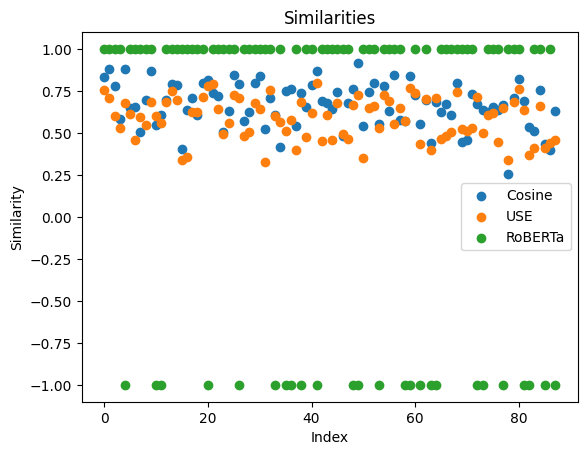

In [56]:
plt.title('Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)
plt.legend(['Cosine', 'USE', 'RoBERTa'])
plt.show()

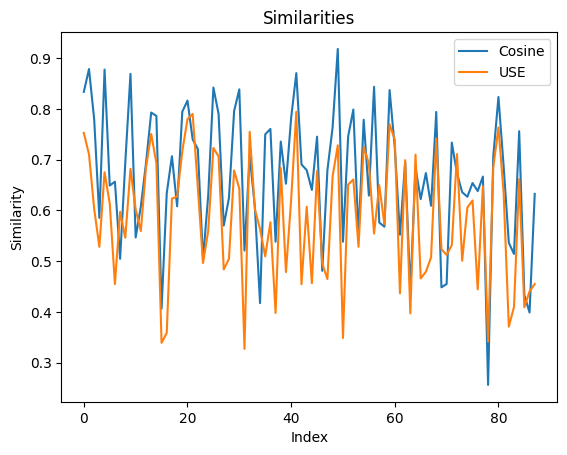

In [57]:
plt.title('Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Cosine', 'USE'])
# plt.plot(x, y3)
# plt.legend(['Cosine', 'USE', 'RoBERTa'])
plt.show()

In [58]:
print('USE SIMILARITY')
print(f'MEAN : {torch.mean(torch.Tensor(fal_USE_similarities).squeeze())}')
print(f'MEDIAN : {torch.median(torch.Tensor(fal_USE_similarities).squeeze())}')

USE SIMILARITY
MEAN : 0.5863038897514343
MEDIAN : 0.6031550765037537


In [59]:
print('COSINE SIMILARITY')
print(f'MEAN : {torch.mean(torch.Tensor(fal_cosine_similarities).squeeze())}')
print(f'MEDIAN : {torch.median(torch.Tensor(fal_cosine_similarities).squeeze())}')


COSINE SIMILARITY
MEAN : 0.6666477918624878
MEDIAN : 0.6738064885139465


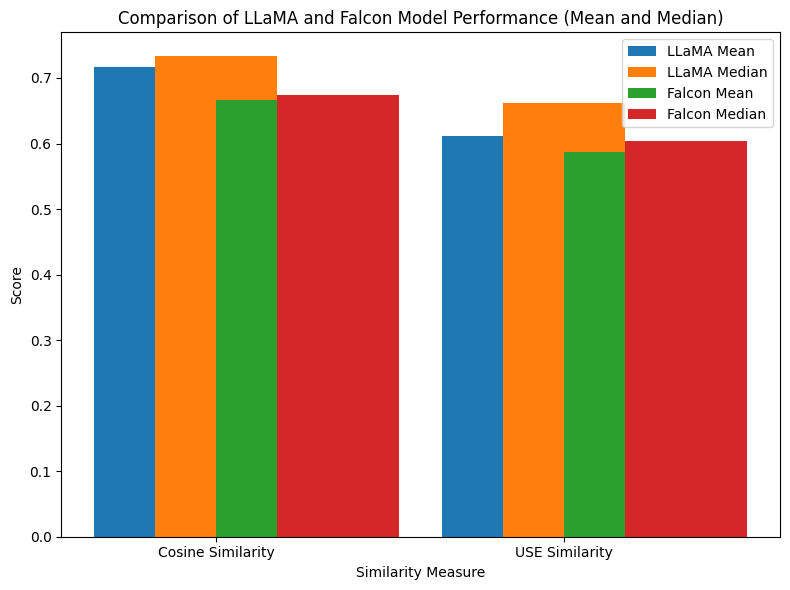

In [60]:
import matplotlib.pyplot as plt

# Data for LLaMA model
llama_means = [0.71706563, 0.61209940]  # Mean values for cosine and USE similarity
llama_medians = [0.73299384, 0.66151130]  # Median values for cosine and USE similarity

# Data for Falcon model
falcon_means = [0.66664779, 0.58630389]  # Mean values for cosine and USE similarity
falcon_medians = [0.67380649, 0.60315508]  # Median values for cosine and USE similarity

# Create a bar plot
index = [0, 1]  # Index for the bars (cosine similarity = 0, USE similarity = 1)
bar_width = 0.35  # Width of each bar

plt.figure(figsize=(8, 6))  # Set the figure size

# Plot LLaMA means
plt.bar(index, llama_means, bar_width, label='LLaMA Mean')

# Plot LLaMA medians on top of means with a slight shift
plt.bar([p + bar_width / 2 for p in index], llama_medians, bar_width, label='LLaMA Median')

# Plot Falcon means
plt.bar([i + bar_width for i in index], falcon_means, bar_width, label='Falcon Mean')

# Plot Falcon medians on top of means with a slight shift
plt.bar([i + bar_width + bar_width / 2 for i in index], falcon_medians, bar_width, label='Falcon Median')

# Set labels and title
plt.xlabel('Similarity Measure')
plt.ylabel('Score')
plt.title('Comparison of LLaMA and Falcon Model Performance (Mean and Median)')

# Add legend
plt.legend()

# Show the plot
plt.xticks([i + bar_width / 2 for i in index], ['Cosine Similarity', 'USE Similarity'])
plt.tight_layout()
plt.show()
